In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Add, Dense, Layer, BatchNormalization, Activation, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
# Clear the session
# K.clear_session()

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

class PrintShapeCallback(Callback):
    def __init__(self, model_layer_name):
        super(PrintShapeCallback, self).__init__()
        self.model_layer_name = model_layer_name

    def on_epoch_end(self, epoch, logs=None):
        # Get the output of the layer with the specified name
        layer_output = self.model.get_layer(self.model_layer_name).output
        print(f"After epoch {epoch+1}, shape of x (from layer {self.model_layer_name}): {layer_output.shape}")

print_shape_callback = PrintShapeCallback(model_layer_name='dense_1')  # Assuming 'dense_1' is the name of the Dense layer after h2(x)

class StopAtThresholdCallback(Callback):
    def __init__(self, threshold):
        super(StopAtThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_loss = logs.get('val_loss')
        if val_loss is not None and val_loss < self.threshold:
            print(f"\nStopping training as validation loss {val_loss} is below the threshold {self.threshold}")
            self.model.stop_training = True

# callback = StopAtThresholdCallback(threshold=1e-03)
callback = StopAtThresholdCallback(threshold=9.8023e-06)

class H1Layer(Layer):
    def __init__(self, **kwargs):
        super(H1Layer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.b = self.add_weight(shape=(input_shape[-1],),
                                initializer=RandomNormal(mean=0.0,stddev=0.03),
                                trainable=True)
        super(H1Layer, self).build(input_shape)

    def call(self, x):
        return self.b * (2 * x)
        #return (2 * x) 


class H2Layer(Layer):
    def __init__(self, h1, **kwargs):
        super(H2Layer, self).__init__(**kwargs)
        self.h1 = h1

    def call(self, x):
        return (2*x*(self.h1(x)))-2
    
class H3Layer(Layer):
    def __init__(self, h1, h2, **kwargs):
        super(H3Layer, self).__init__(**kwargs)
        self.h1 = h1
        self.h2 = h2
        
    def call(self, x):
        return (2*x*(self.h2(x)))-(4*self.h1(x))

class H4Layer(Layer):
    def __init__(self, h2, h3, **kwargs):
        super(H4Layer, self).__init__(**kwargs)
        self.h2 = h2
        self.h3 = h3

    def call(self, x):
        return (2*x*(self.h3(x)))-(6*self.h2(x))   

class H5Layer(Layer):
    def __init__(self, h3, h4, **kwargs):
        super(H5Layer,self).__init__(**kwargs)
        self.h3 = h3
        self.h4 = h4

    def call(self,x):
        return (2*x*(self.h4(x)))-(8*self.h3(x))
    
class H6Layer(Layer):
    def __init__(self, h4, h5, **kwargs):
        super(H6Layer,self).__init__(**kwargs)
        self.h4 = h4
        self.h5 = h5

    def call(self,x):
        return (2*x*(self.h5(x)))-(10*self.h4(x))

class TensorDecompositionLayer(Layer):
    def __init__(self, rank, **kwargs):
        self.rank = rank
        super(TensorDecompositionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.factors_a = self.add_weight(shape=(input_shape[-1], self.rank),
                                         initializer=RandomNormal(mean=0.0,stddev=0.05),
                                         trainable=True)
        self.factors_b = self.add_weight(shape=(self.rank, input_shape[-1]),
                                        initializer=RandomNormal(mean=0.0,stddev=0.05),
                                        trainable=True)
        super(TensorDecompositionLayer, self).build(input_shape)

    def call(self, x):
        return tf.matmul(tf.matmul(x, self.factors_a), self.factors_b)

 
class Relu_With_Weight(Layer):
    def __init__(self, **kwargs):
        super(Relu_With_Weight, self).__init__(**kwargs)

    def build(self, input_shape):
        self.b = self.add_weight(shape=(input_shape[-1],),
                                initializer=RandomNormal(),
                                trainable=True)
        super(Relu_With_Weight, self).build(input_shape)

    def call(self, x):
        return K.tanh(x * self.b)

2023-11-16 15:53:08.621590: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-16 15:53:09.092259: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# f(x1,x2)=3cos(2pi( x1^2-x2^2)) Prediction
## Our method / CP decomposition 
* n = 4
* 64 Neurons per Dense layer 
* Lr: 0.0001
* Batch Size: 64
* Epochs: 50, Stopping when prediction better than 1e-04
* 1000 Samples -1 to 1


2023-11-02 15:51:33.353358: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-02 15:51:33.372055: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-02 15:51:33.372239: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Epoch 1/20


2023-11-02 15:51:35.892296: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-11-02 15:51:35.893783: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fbeed9adee0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-02 15:51:35.893794: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2023-11-02 15:51:35.896926: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-02 15:51:36.011511: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-11-02 15:51:36.099470: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.

6250/6250 [==============================] - 25s 3ms/step - loss: 3.2865 - val_loss: 3.2053
Epoch 2/20
6250/6250 [==============================] - 21s 3ms/step - loss: 3.0963 - val_loss: 3.0983
Epoch 3/20
6250/6250 [==============================] - 21s 3ms/step - loss: 3.0753 - val_loss: 3.0708
Epoch 4/20
6250/6250 [==============================] - 22s 3ms/step - loss: 3.0704 - val_loss: 3.0455
Epoch 5/20
6250/6250 [==============================] - 21s 3ms/step - loss: 0.4775 - val_loss: 1.6457e-04
Epoch 6/20
6250/6250 [==============================] - 22s 3ms/step - loss: 0.0021 - val_loss: 4.9265e-04
Epoch 7/20
6250/6250 [==============================] - 21s 3ms/step - loss: 0.0016 - val_loss: 8.5024e-04
Epoch 8/20
6250/6250 [==============================] - 22s 3ms/step - loss: 0.0014 - val_loss: 8.4651e-05
Epoch 9/20
6250/6250 [==============================] - 22s 3ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 10/20
6250/6250 [==============================] - 22s 3ms/ste

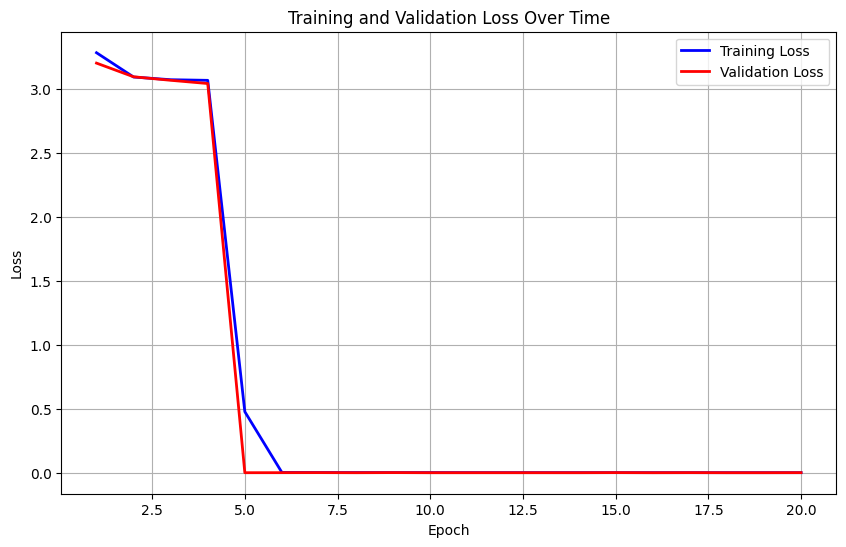

In [2]:

# Define the function
def f(x1, x2):
    return 3 * np.cos(2 * np.pi * (x1**2 - x2**2))

# Set the parameters
lower_bound = -1
upper_bound = 1
n_samples = 1000

# Generate the data
x1_values = np.linspace(lower_bound, upper_bound, n_samples).reshape(n_samples, 1)
x2_values = np.linspace(lower_bound, upper_bound, n_samples).reshape(n_samples, 1)

# Get a meshgrid for x1 and x2 values
X1, X2 = np.meshgrid(x1_values, x2_values)

# Calculate y values using the function
y_values = f(X1, X2)

# Reshape the data for training
X = np.column_stack((X1.ravel(), X2.ravel()))
y = y_values.ravel()

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Assuming H1Layer, H2Layer, H3Layer, H4Layer, H5Layer, and TensorDecompositionLayer are pre-defined
def build_model(input_shape, filters):
    rank = 4
    input_layer = Input(shape=input_shape)
    x = input_layer

    h1 = H1Layer()
    h2 = H2Layer(h1)
    h3 = H3Layer(h1,h2)
    h4 = H4Layer(h2,h3)
    h5 = H5Layer(h3,h4)

    # Using 'he_normal' initialization for the Dense layers
    x = Dense(filters, kernel_initializer='he_normal')(x)
    x = h2(x)
    x = Dense(filters, kernel_initializer='he_normal')(x)
    x = TensorDecompositionLayer(rank)(x)
    x = h3(x)
    x = Dense(filters, kernel_initializer='he_normal')(x)
    x = TensorDecompositionLayer(rank)(x)
    x = h4(x)
    x = Dense(filters, kernel_initializer='he_normal')(x)
    x = TensorDecompositionLayer(rank)(x)
    x = h5(x)
    x = Dense(filters, kernel_initializer='he_normal')(x)
    x = TensorDecompositionLayer(rank)(x)
    
    output_layer = Dense(1, )(x)
    model = Model(inputs=input_layer, outputs=output_layer)

    return model 


input_shape = (2,)
filters = 128
modelN4 = build_model(input_shape, filters)
optimizer = Adam(learning_rate=0.0001) # Reduce learning rate
modelN4.compile(optimizer=optimizer, loss='mse')

batch_size = 128
epochs = 20

history = modelN4.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_val, y_val),
                    callbacks=[callback])

val_loss = modelN4.evaluate(X_val, y_val, verbose=0)
print(f"Validation loss: {val_loss}")

import matplotlib.pyplot as plt
modelN4.summary()

# 1. Extract loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# 2. Determine the number of epochs
actual_epochs = len(train_loss)

# 3. Create a plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, actual_epochs + 1), train_loss, label='Training Loss', color='b', linewidth=2)
plt.plot(range(1, actual_epochs + 1), val_loss, label='Validation Loss', color='r', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.grid()
plt.show()

313/313 [==============================] - 1s 1ms/step


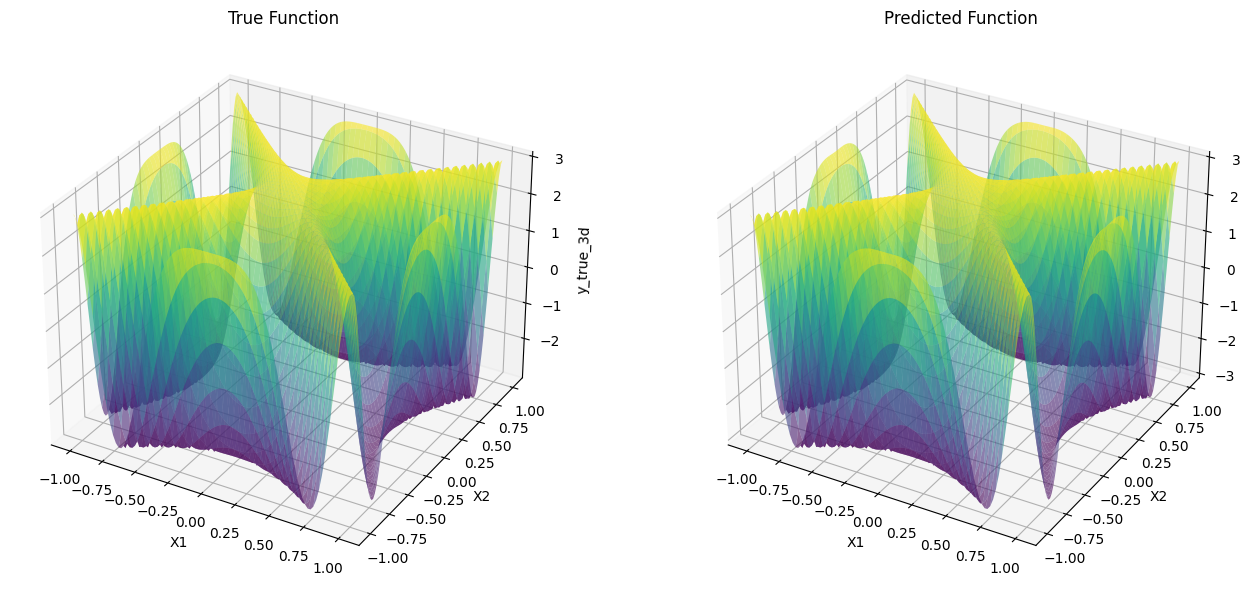

In [3]:

import matplotlib.pyplot as plt

num_test_samples = 100
x1_test_values = np.linspace(lower_bound, upper_bound, num=num_test_samples).reshape(-1, 1)
x2_test_values = np.linspace(lower_bound, upper_bound, num=num_test_samples).reshape(-1, 1)

# Get a meshgrid for x1 and x2 test values
X1_test, X2_test = np.meshgrid(x1_test_values, x2_test_values)

# Calculate y true values using the function
y_true_3d = f(X1_test, X2_test)

X_test_3d = np.column_stack((X1_test.ravel(), X2_test.ravel()))
y_true_3d = y_true_3d.ravel()

# Predict y values using the trained model
y_pred_3d = modelN4.predict(X_test_3d)

# Reshape the predicted y values to match the shape of X1_test and X2_test
y_pred_3d_reshaped = y_pred_3d.reshape(X1_test.shape)

# 3D visualization of the data with real and predicted values
fig = plt.figure(figsize=(14, 6))

# True values subplot
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(X1_test, X2_test, y_true_3d.reshape(X1_test.shape), cmap='viridis', alpha=0.6)
ax1.set_xlabel('X1')
ax1.set_ylabel('X2')
ax1.set_zlabel('y_true_3d')
ax1.set_title('True Function')
ax1.grid(True)

# Predicted values subplot
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(X1_test, X2_test, y_pred_3d_reshaped, cmap='viridis', alpha=0.6)
ax2.set_xlabel('X1')
ax2.set_ylabel('X2')
ax2.set_zlabel('y_pred_3d')
ax2.set_title('Predicted Function')
ax2.grid(True)

plt.tight_layout()
plt.show()

# Our method Xavier/Glorot

In [2]:

# Define the function
def f(x1, x2):
    return 3 * np.cos(2 * np.pi * (x1**2 - x2**2))

# Set the parameters
lower_bound = -1
upper_bound = 1
n_samples = 1000

# Generate the data
x1_values = np.linspace(lower_bound, upper_bound, n_samples).reshape(n_samples, 1)
x2_values = np.linspace(lower_bound, upper_bound, n_samples).reshape(n_samples, 1)

# Get a meshgrid for x1 and x2 values
X1, X2 = np.meshgrid(x1_values, x2_values)

# Calculate y values using the function
y_values = f(X1, X2)

# Reshape the data for training
X = np.column_stack((X1.ravel(), X2.ravel()))
y = y_values.ravel()

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Assuming H1Layer, H2Layer, H3Layer, H4Layer, H5Layer, and TensorDecompositionLayer are pre-defined
def build_model(input_shape, filters):
    rank = 3
    input_layer = Input(shape=input_shape)
    x = input_layer

    h1 = H1Layer()
    h2 = H2Layer(h1)
    h3 = H3Layer(h1,h2)
    h4 = H4Layer(h2,h3)
    h5 = H5Layer(h3,h4)

    # Using 'he_normal' initialization for the Dense layers
    x = Dense(filters)(x)
    x = h2(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)
    x = h3(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)
    x = h4(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)
    x = h5(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)
    
    output_layer = Dense(1, )(x)
    model = Model(inputs=input_layer, outputs=output_layer)

    return model 


input_shape = (2,)
filters = 128
modelN4 = build_model(input_shape, filters)
optimizer = Adam(learning_rate=0.0001) # Reduce learning rate
modelN4.compile(optimizer=optimizer, loss='mse')

batch_size = 64
epochs = 20

history = modelN4.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_val, y_val),
                    callbacks=[callback])

val_loss = modelN4.evaluate(X_val, y_val, verbose=0)
print(f"Validation loss: {val_loss}")

import matplotlib.pyplot as plt
modelN4.summary()

# 1. Extract loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# 2. Determine the number of epochs
actual_epochs = len(train_loss)

# 3. Create a plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, actual_epochs + 1), train_loss, label='Training Loss', color='b', linewidth=2)
plt.plot(range(1, actual_epochs + 1), val_loss, label='Validation Loss', color='r', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.grid()
plt.show()

2023-11-02 12:11:45.595820: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-02 12:11:45.611051: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-02 12:11:45.611240: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Epoch 1/20


2023-11-02 12:11:48.056547: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-11-02 12:11:48.057974: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fb171ff9ea0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-02 12:11:48.057985: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2023-11-02 12:11:48.061315: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-02 12:11:48.172384: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-11-02 12:11:48.263602: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.

12500/12500 [==============================] - 45s 3ms/step - loss: 4.6582 - val_loss: 4.6628
Epoch 2/20
12500/12500 [==============================] - 42s 3ms/step - loss: 4.6557 - val_loss: 4.6531
Epoch 3/20
12500/12500 [==============================] - 42s 3ms/step - loss: 3.6590 - val_loss: 3.0935
Epoch 4/20
12500/12500 [==============================] - 42s 3ms/step - loss: 3.1092 - val_loss: 3.0636
Epoch 5/20
12500/12500 [==============================] - 42s 3ms/step - loss: 3.0764 - val_loss: 3.0443
Epoch 6/20
12500/12500 [==============================] - 42s 3ms/step - loss: 1887233900544.0000 - val_loss: 1320.0818
Epoch 7/20
12500/12500 [==============================] - 41s 3ms/step - loss: 1276.2056 - val_loss: 1036.5751
Epoch 8/20
12500/12500 [==============================] - 43s 3ms/step - loss: 460.7833 - val_loss: 7.0854
Epoch 9/20
12500/12500 [==============================] - 42s 3ms/step - loss: 3.7566 - val_loss: 3.3079
Epoch 10/20
12500/12500 [==================

KeyboardInterrupt: 

# 150 EPOCHS - VAL Loss:  stopped at epoch 13

In [2]:
# Define the function
def f(x1, x2):
    return 3 * np.cos(2 * np.pi * (x1**2 - x2**2))

# Set the parameters
lower_bound = -1
upper_bound = 1
n_samples = 1000

# Generate the data
x1_values = np.linspace(lower_bound, upper_bound, n_samples).reshape(n_samples, 1)
x2_values = np.linspace(lower_bound, upper_bound, n_samples).reshape(n_samples, 1)

# Get a meshgrid for x1 and x2 values
X1, X2 = np.meshgrid(x1_values, x2_values)

# Calculate y values using the function
y_values = f(X1, X2)

# Reshape the data for training
X = np.column_stack((X1.ravel(), X2.ravel()))
y = y_values.ravel()

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Assuming H1Layer, H2Layer, H3Layer, H4Layer, H5Layer, and TensorDecompositionLayer are pre-defined
def build_model(input_shape, filters):
    rank = 3
    input_layer = Input(shape=input_shape)
    x = input_layer

    h1 = H1Layer()
    h2 = H2Layer(h1)
    h3 = H3Layer(h1,h2)
    h4 = H4Layer(h2,h3)
    h5 = H5Layer(h3,h4)

    # Using 'he_normal' initialization for the Dense layers
    x = Dense(filters, )(x)
    x = h2(x)
    x = Dense(filters, )(x)
    x = TensorDecompositionLayer(rank)(x)
    x = h3(x)
    x = Dense(filters, )(x)
    x = TensorDecompositionLayer(rank)(x)
    x = h4(x)
    x = Dense(filters, )(x)
    x = TensorDecompositionLayer(rank)(x)
    x = h5(x)
    x = Dense(filters, )(x)
    x = TensorDecompositionLayer(rank)(x)
    
    output_layer = Dense(1, )(x)
    model = Model(inputs=input_layer, outputs=output_layer)

    return model 


input_shape = (2,)
filters = 128
modelN4 = build_model(input_shape, filters)
optimizer = Adam(learning_rate=0.0001) # Reduce learning rate
modelN4.compile(optimizer=optimizer, loss='mse')

batch_size = 64
epochs = 50

history = modelN4.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_val, y_val),
                    callbacks=[callback])

val_loss = modelN4.evaluate(X_val, y_val, verbose=0)
print(f"Validation loss: {val_loss}")


import matplotlib.pyplot as plt
modelN4.summary()

# 1. Extract loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# 2. Determine the number of epochs
actual_epochs = len(train_loss)

# 3. Create a plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, actual_epochs + 1), train_loss, label='Training Loss', color='b', linewidth=2)
plt.plot(range(1, actual_epochs + 1), val_loss, label='Validation Loss', color='r', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.grid()
plt.show()

2023-10-24 13:05:04.704912: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-24 13:05:04.720850: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-24 13:05:04.721040: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Epoch 1/150


2023-10-24 13:05:07.135886: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-10-24 13:05:07.137310: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f3be4c76420 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-24 13:05:07.137321: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2023-10-24 13:05:07.140435: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-24 13:05:07.245995: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-10-24 13:05:07.333798: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.

12500/12500 [==============================] - 47s 4ms/step - loss: 3.1637 - val_loss: 3.2016
Epoch 2/150
12500/12500 [==============================] - 44s 3ms/step - loss: 3.0780 - val_loss: 3.0602
Epoch 3/150
12500/12500 [==============================] - 44s 3ms/step - loss: 3.0695 - val_loss: 3.0641
Epoch 4/150
12500/12500 [==============================] - 43s 3ms/step - loss: 1.3644 - val_loss: 0.5031
Epoch 5/150
12500/12500 [==============================] - 44s 3ms/step - loss: 0.2774 - val_loss: 0.4022
Epoch 6/150
12500/12500 [==============================] - 43s 3ms/step - loss: 0.1498 - val_loss: 0.0556
Epoch 7/150
12500/12500 [==============================] - 43s 3ms/step - loss: 0.1258 - val_loss: 0.0534
Epoch 8/150
12500/12500 [==============================] - 42s 3ms/step - loss: 0.3429 - val_loss: 0.0357
Epoch 9/150
12500/12500 [==============================] - 43s 3ms/step - loss: 0.0968 - val_loss: 0.0480
Epoch 10/150
12500/12500 [==============================] 

KeyboardInterrupt: 

313/313 [==============================] - 0s 1ms/step


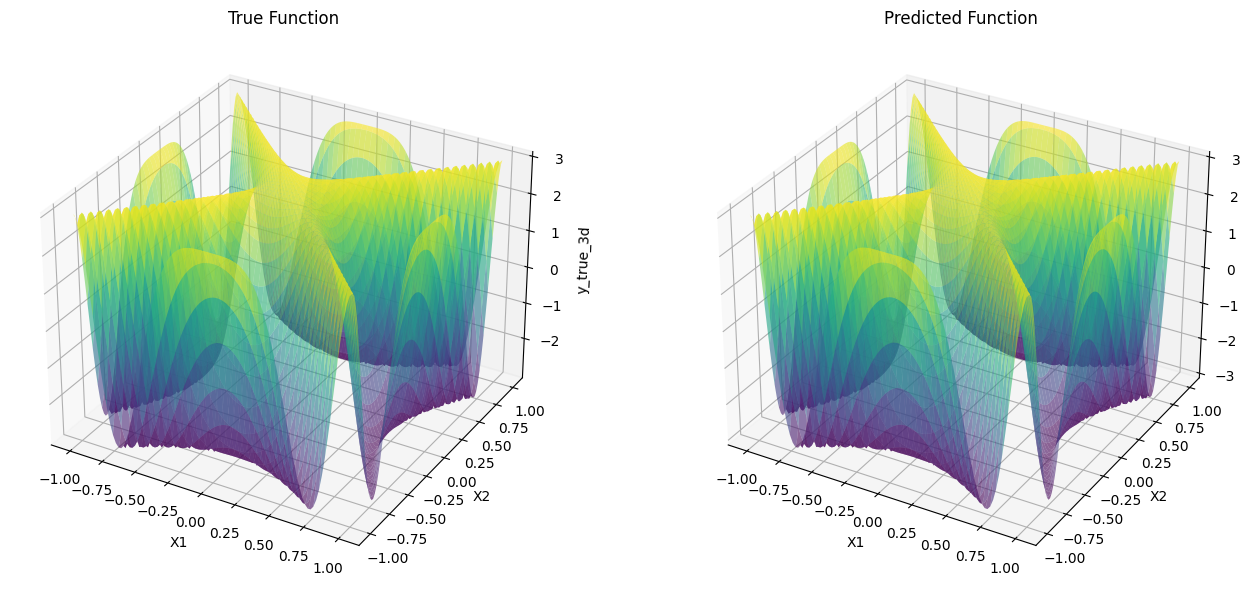

In [4]:

import matplotlib.pyplot as plt

num_test_samples = 100
x1_test_values = np.linspace(lower_bound, upper_bound, num=num_test_samples).reshape(-1, 1)
x2_test_values = np.linspace(lower_bound, upper_bound, num=num_test_samples).reshape(-1, 1)

# Get a meshgrid for x1 and x2 test values
X1_test, X2_test = np.meshgrid(x1_test_values, x2_test_values)

# Calculate y true values using the function
y_true_3d = f(X1_test, X2_test)

X_test_3d = np.column_stack((X1_test.ravel(), X2_test.ravel()))
y_true_3d = y_true_3d.ravel()

# Predict y values using the trained model
y_pred_3d = modelN4.predict(X_test_3d)

# Reshape the predicted y values to match the shape of X1_test and X2_test
y_pred_3d_reshaped = y_pred_3d.reshape(X1_test.shape)

# 3D visualization of the data with real and predicted values
fig = plt.figure(figsize=(14, 6))

# True values subplot
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(X1_test, X2_test, y_true_3d.reshape(X1_test.shape), cmap='viridis', alpha=0.6)
ax1.set_xlabel('X1')
ax1.set_ylabel('X2')
ax1.set_zlabel('y_true_3d')
ax1.set_title('True Function')
ax1.grid(True)

# Predicted values subplot
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(X1_test, X2_test, y_pred_3d_reshaped, cmap='viridis', alpha=0.6)
ax2.set_xlabel('X1')
ax2.set_ylabel('X2')
ax2.set_zlabel('y_pred_3d')
ax2.set_title('Predicted Function')
ax2.grid(True)

plt.tight_layout()
plt.show()

# Batch Normalization


In [3]:

# Define the function
def f(x1, x2):
    return 3 * np.cos(2 * np.pi * (x1**2 - x2**2))

# Set the parameters
lower_bound = -1
upper_bound = 1
n_samples = 1000

# Generate the data
x1_values = np.linspace(lower_bound, upper_bound, n_samples).reshape(n_samples, 1)
x2_values = np.linspace(lower_bound, upper_bound, n_samples).reshape(n_samples, 1)

# Get a meshgrid for x1 and x2 values
X1, X2 = np.meshgrid(x1_values, x2_values)

# Calculate y values using the function
y_values = f(X1, X2)

# Reshape the data for training
X = np.column_stack((X1.ravel(), X2.ravel()))
y = y_values.ravel()

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Assuming H1Layer, H2Layer, H3Layer, H4Layer, H5Layer, and TensorDecompositionLayer are pre-defined
def build_model(input_shape, filters):
    rank = 3
    input_layer = Input(shape=input_shape)
    x = input_layer

    h1 = H1Layer()
    h2 = H2Layer(h1)
    h3 = H3Layer(h1,h2)
    h4 = H4Layer(h2,h3)
    h5 = H5Layer(h3,h4)

    # Using 'he_normal' initialization for the Dense layers
    x = Dense(filters, )(x)
    x = h2(x)
    x = Dense(filters, )(x)
    x = BatchNormalization()(x)
    x = h3(x)
    x = Dense(filters, )(x)
    x = BatchNormalization()(x)
    x = h4(x)
    x = Dense(filters, )(x)
    x = BatchNormalization()(x)
    x = h5(x)
    x = Dense(filters, )(x)
    x = BatchNormalization()(x)
    
    output_layer = Dense(1, )(x)
    model = Model(inputs=input_layer, outputs=output_layer)

    return model 


input_shape = (2,)
filters = 128
modelN4 = build_model(input_shape, filters)
modelN4.summary()
optimizer = Adam(learning_rate=0.0001) # Reduce learning rate
modelN4.compile(optimizer=optimizer, loss='mse')

batch_size = 64
epochs = 20

history = modelN4.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_val, y_val),
                    callbacks=[callback])

val_loss = modelN4.evaluate(X_val, y_val, verbose=0)
print(f"Validation loss: {val_loss}")

import matplotlib.pyplot as plt
modelN4.summary()

# 1. Extract loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# 2. Determine the number of epochs
actual_epochs = len(train_loss)

# 3. Create a plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, actual_epochs + 1), train_loss, label='Training Loss', color='b', linewidth=2)
plt.plot(range(1, actual_epochs + 1), val_loss, label='Validation Loss', color='r', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.grid()
plt.show()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_6 (Dense)             (None, 128)               384       
                                                                 
 h2_layer_1 (H2Layer)        (None, 128)               128       
                                                                 
 dense_7 (Dense)             (None, 128)               16512     
                                                                 
 batch_normalization_4 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 h3_layer_1 (H3Layer)        (None, 128)               128       
                                                           

KeyboardInterrupt: 

# Relu

2023-11-01 16:43:24.305519: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


Epoch 1/20


2023-11-01 16:43:24.321673: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-01 16:43:24.321860: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-01 16:43:24.323757: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

12500/12500 [==============================] - 29s 2ms/step - loss: 0.0524 - val_loss: 0.0119
Epoch 2/20
12500/12500 [==============================] - 27s 2ms/step - loss: 0.0078 - val_loss: 0.0287
Epoch 3/20
12500/12500 [==============================] - 27s 2ms/step - loss: 0.0049 - val_loss: 0.0019
Epoch 4/20
12500/12500 [==============================] - 27s 2ms/step - loss: 0.0040 - val_loss: 0.0019
Epoch 5/20
12500/12500 [==============================] - 27s 2ms/step - loss: 0.0033 - val_loss: 0.0030
Epoch 6/20
12500/12500 [==============================] - 27s 2ms/step - loss: 0.0026 - val_loss: 8.1591e-04
Epoch 7/20
12500/12500 [==============================] - 27s 2ms/step - loss: 0.0024 - val_loss: 0.0012
Epoch 8/20
12500/12500 [==============================] - 27s 2ms/step - loss: 0.0021 - val_loss: 0.0045
Epoch 9/20
12500/12500 [==============================] - 27s 2ms/step - loss: 0.0019 - val_loss: 0.0055
Epoch 10/20
12500/12500 [==============================] - 27s

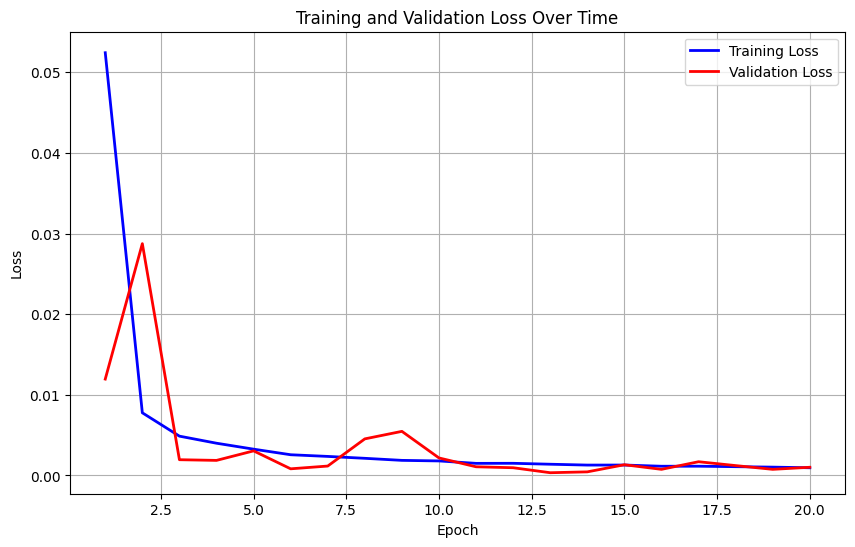

In [2]:

# Define the function
def f(x1, x2):
    return 3 * np.cos(2 * np.pi * (x1**2 - x2**2))

# Set the parameters
lower_bound = -1
upper_bound = 1
n_samples = 1000

# Generate the data
x1_values = np.linspace(lower_bound, upper_bound, n_samples).reshape(n_samples, 1)
x2_values = np.linspace(lower_bound, upper_bound, n_samples).reshape(n_samples, 1)

# Get a meshgrid for x1 and x2 values
X1, X2 = np.meshgrid(x1_values, x2_values)

# Calculate y values using the function
y_values = f(X1, X2)

# Reshape the data for training
X = np.column_stack((X1.ravel(), X2.ravel()))
y = y_values.ravel()

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Assuming H1Layer, H2Layer, H3Layer, H4Layer, H5Layer, and TensorDecompositionLayer are pre-defined
def build_model(input_shape, filters):
    input_layer = Input(shape=input_shape)
    x = input_layer

    # Using 'he_normal' initialization for the Dense layers
    x = Dense(filters,activation="relu")(x)
    x = Dense(filters,activation="relu")(x)
    x = Dense(filters,activation="relu")(x)
    x = Dense(filters,activation="relu")(x)
    x = Dense(filters,activation="relu")(x)
    
    output_layer = Dense(1)(x)
    model = Model(inputs=input_layer, outputs=output_layer)

    return model 


input_shape = (2,)
filters = 128
modelN4 = build_model(input_shape, filters)
optimizer = Adam(learning_rate=0.001) # Reduce learning rate
modelN4.compile(optimizer=optimizer, loss='mse')

batch_size = 64
epochs = 20

history = modelN4.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_val, y_val),
                    callbacks=[callback])

val_loss = modelN4.evaluate(X_val, y_val, verbose=0)
print(f"Validation loss: {val_loss}")

import matplotlib.pyplot as plt
modelN4.summary()

# 1. Extract loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# 2. Determine the number of epochs
actual_epochs = len(train_loss)

# 3. Create a plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, actual_epochs + 1), train_loss, label='Training Loss', color='b', linewidth=2)
plt.plot(range(1, actual_epochs + 1), val_loss, label='Validation Loss', color='r', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.grid()
plt.show()

# Sigmoid

2023-11-01 16:54:54.403572: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


Epoch 1/20


2023-11-01 16:54:54.419599: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-01 16:54:54.419785: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-01 16:54:54.421723: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

12500/12500 [==============================] - 30s 2ms/step - loss: 4.6553 - val_loss: 4.6615
Epoch 2/20
12500/12500 [==============================] - 28s 2ms/step - loss: 4.6539 - val_loss: 4.6528
Epoch 3/20
12500/12500 [==============================] - 28s 2ms/step - loss: 4.6534 - val_loss: 4.6527
Epoch 4/20
12500/12500 [==============================] - 28s 2ms/step - loss: 4.6466 - val_loss: 4.5832
Epoch 5/20
12500/12500 [==============================] - 28s 2ms/step - loss: 3.9691 - val_loss: 3.5878
Epoch 6/20
12500/12500 [==============================] - 28s 2ms/step - loss: 2.7998 - val_loss: 2.2708
Epoch 7/20
12500/12500 [==============================] - 28s 2ms/step - loss: 1.8604 - val_loss: 0.9965
Epoch 8/20
12500/12500 [==============================] - 28s 2ms/step - loss: 0.4229 - val_loss: 0.1670
Epoch 9/20
12500/12500 [==============================] - 28s 2ms/step - loss: 0.0859 - val_loss: 0.0411
Epoch 10/20
12500/12500 [==============================] - 28s 2ms

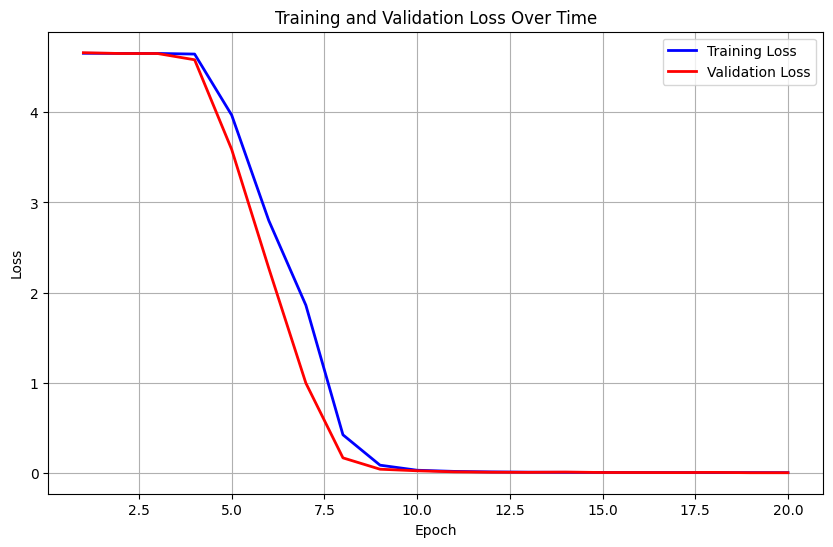

In [2]:

# Define the function
def f(x1, x2):
    return 3 * np.cos(2 * np.pi * (x1**2 - x2**2))

# Set the parameters
lower_bound = -1
upper_bound = 1
n_samples = 1000

# Generate the data
x1_values = np.linspace(lower_bound, upper_bound, n_samples).reshape(n_samples, 1)
x2_values = np.linspace(lower_bound, upper_bound, n_samples).reshape(n_samples, 1)

# Get a meshgrid for x1 and x2 values
X1, X2 = np.meshgrid(x1_values, x2_values)

# Calculate y values using the function
y_values = f(X1, X2)

# Reshape the data for training
X = np.column_stack((X1.ravel(), X2.ravel()))
y = y_values.ravel()

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Assuming H1Layer, H2Layer, H3Layer, H4Layer, H5Layer, and TensorDecompositionLayer are pre-defined
def build_model(input_shape, filters):
    input_layer = Input(shape=input_shape)
    x = input_layer

    # Using 'he_normal' initialization for the Dense layers
    x = Dense(filters,activation="sigmoid")(x)
    x = Dense(filters,activation="sigmoid")(x)
    x = Dense(filters,activation="sigmoid")(x)
    x = Dense(filters,activation="sigmoid")(x)
    x = Dense(filters,activation="sigmoid")(x)
    
    output_layer = Dense(1)(x)
    model = Model(inputs=input_layer, outputs=output_layer)

    return model 


input_shape = (2,)
filters = 128
modelN4 = build_model(input_shape, filters)
optimizer = Adam(learning_rate=0.0001) # Reduce learning rate
modelN4.compile(optimizer=optimizer, loss='mse')

batch_size = 64
epochs = 20

history = modelN4.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_val, y_val),
                    callbacks=[callback])

val_loss = modelN4.evaluate(X_val, y_val, verbose=0)
print(f"Validation loss: {val_loss}")

import matplotlib.pyplot as plt
modelN4.summary()

# 1. Extract loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# 2. Determine the number of epochs
actual_epochs = len(train_loss)

# 3. Create a plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, actual_epochs + 1), train_loss, label='Training Loss', color='b', linewidth=2)
plt.plot(range(1, actual_epochs + 1), val_loss, label='Validation Loss', color='r', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.grid()
plt.show()

# Tanh

2023-11-16 14:46:31.758170: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


Epoch 1/20


2023-11-16 14:46:31.773906: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-16 14:46:31.774097: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-16 14:46:31.775973: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

6250/6250 [==============================] - 15s 2ms/step - loss: 0.7058 - val_loss: 0.0014
Epoch 2/20
6250/6250 [==============================] - 13s 2ms/step - loss: 8.6120e-04 - val_loss: 0.0010
Epoch 3/20
6250/6250 [==============================] - 13s 2ms/step - loss: 5.3037e-04 - val_loss: 2.9071e-04
Epoch 4/20
6250/6250 [==============================] - 13s 2ms/step - loss: 4.2212e-04 - val_loss: 1.9098e-04
Epoch 5/20
6250/6250 [==============================] - 13s 2ms/step - loss: 3.0649e-04 - val_loss: 3.4390e-04
Epoch 6/20
6250/6250 [==============================] - 13s 2ms/step - loss: 2.7538e-04 - val_loss: 1.6648e-04
Epoch 7/20
6250/6250 [==============================] - 13s 2ms/step - loss: 2.4802e-04 - val_loss: 1.7204e-04
Epoch 8/20
6250/6250 [==============================] - 13s 2ms/step - loss: 2.1269e-04 - val_loss: 4.2526e-04
Epoch 9/20
6250/6250 [==============================] - 13s 2ms/step - loss: 1.9893e-04 - val_loss: 2.4313e-04
Epoch 10/20
6250/6250 [=

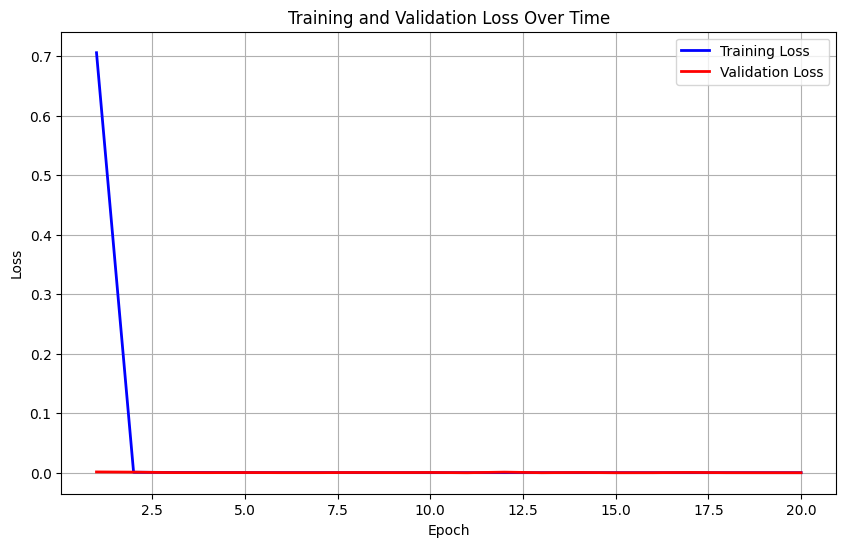

In [2]:

# Define the function
def f(x1, x2):
    return 3 * np.cos(2 * np.pi * (x1**2 - x2**2))

# Set the parameters
lower_bound = -1
upper_bound = 1
n_samples = 1000

# Generate the data
x1_values = np.linspace(lower_bound, upper_bound, n_samples).reshape(n_samples, 1)
x2_values = np.linspace(lower_bound, upper_bound, n_samples).reshape(n_samples, 1)

# Get a meshgrid for x1 and x2 values
X1, X2 = np.meshgrid(x1_values, x2_values)

# Calculate y values using the function
y_values = f(X1, X2)

# Reshape the data for training
X = np.column_stack((X1.ravel(), X2.ravel()))
y = y_values.ravel()

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Assuming H1Layer, H2Layer, H3Layer, H4Layer, H5Layer, and TensorDecompositionLayer are pre-defined
def build_model(input_shape, filters):
    input_layer = Input(shape=input_shape)
    x = input_layer

    # Using 'he_normal' initialization for the Dense layers
    x = Dense(filters,activation="tanh")(x)
    x = Dense(filters,activation="tanh")(x)
    x = Dense(filters,activation="tanh")(x)
    x = Dense(filters,activation="tanh")(x)
    x = Dense(filters,activation="tanh")(x)
    
    output_layer = Dense(1, )(x)
    model = Model(inputs=input_layer, outputs=output_layer)

    return model 


input_shape = (2,)
filters = 128
modelN4 = build_model(input_shape, filters)
optimizer = Adam(learning_rate=0.0001) # Reduce learning rate
modelN4.compile(optimizer=optimizer, loss='mse')

batch_size = 128
epochs = 20

history = modelN4.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_val, y_val),
                    callbacks=[callback])

val_loss = modelN4.evaluate(X_val, y_val, verbose=0)
print(f"Validation loss: {val_loss}")

import matplotlib.pyplot as plt
modelN4.summary()

# 1. Extract loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# 2. Determine the number of epochs
actual_epochs = len(train_loss)

# 3. Create a plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, actual_epochs + 1), train_loss, label='Training Loss', color='b', linewidth=2)
plt.plot(range(1, actual_epochs + 1), val_loss, label='Validation Loss', color='r', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.grid()
plt.show()

# 2 var relu + tensor decomposition

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 128)               384       
                                                                 
 activation (Activation)     (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 tensor_decomposition_layer  (None, 128)               768       
  (TensorDecompositionLayer                                      
 )                                                               
                                                                 
 activation_1 (Activation)   (None, 128)               0     

2023-11-01 17:20:34.723075: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-01 17:20:34.739265: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-01 17:20:34.739445: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

12500/12500 [==============================] - 37s 3ms/step - loss: 0.2131 - val_loss: 0.0015
Epoch 2/20
12500/12500 [==============================] - 34s 3ms/step - loss: 0.0031 - val_loss: 0.0035
Epoch 3/20
12500/12500 [==============================] - 34s 3ms/step - loss: 0.0026 - val_loss: 8.6018e-04
Epoch 4/20
12500/12500 [==============================] - 34s 3ms/step - loss: 0.0022 - val_loss: 0.0017
Epoch 5/20
12500/12500 [==============================] - 34s 3ms/step - loss: 0.0019 - val_loss: 6.4747e-04
Epoch 6/20
12500/12500 [==============================] - 34s 3ms/step - loss: 0.0018 - val_loss: 5.3625e-04
Epoch 7/20
12500/12500 [==============================] - 34s 3ms/step - loss: 0.0017 - val_loss: 0.0021
Epoch 8/20
12500/12500 [==============================] - 34s 3ms/step - loss: 0.0017 - val_loss: 0.0032
Epoch 9/20
12500/12500 [==============================] - 34s 3ms/step - loss: 0.0016 - val_loss: 6.7902e-04
Epoch 10/20
12500/12500 [=========================

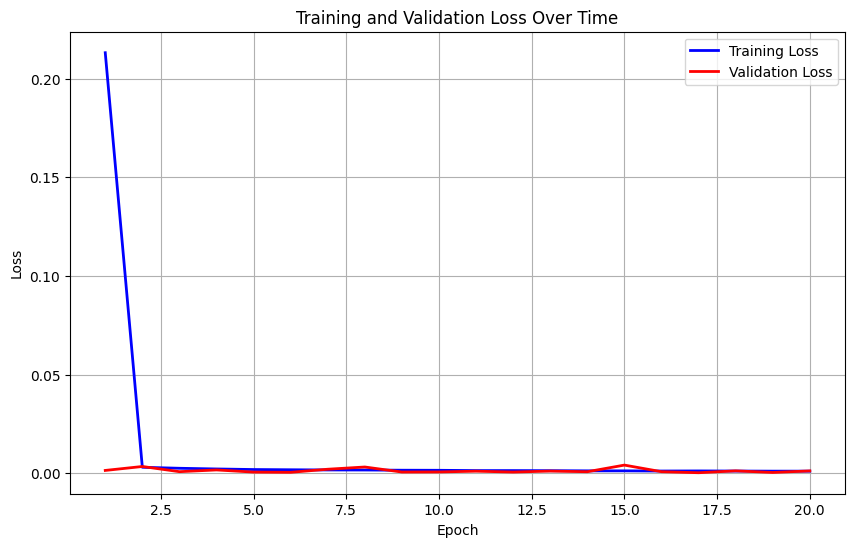

In [2]:

# Define the function
def f(x1, x2):
    return 3 * np.cos(2 * np.pi * (x1**2 - x2**2))

# Set the parameters
lower_bound = -1
upper_bound = 1
n_samples = 1000

# Generate the data
x1_values = np.linspace(lower_bound, upper_bound, n_samples).reshape(n_samples, 1)
x2_values = np.linspace(lower_bound, upper_bound, n_samples).reshape(n_samples, 1)

# Get a meshgrid for x1 and x2 values
X1, X2 = np.meshgrid(x1_values, x2_values)

# Calculate y values using the function
y_values = f(X1, X2)

# Reshape the data for training
X = np.column_stack((X1.ravel(), X2.ravel()))
y = y_values.ravel()

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Assuming H1Layer, H2Layer, H3Layer, H4Layer, H5Layer, and TensorDecompositionLayer are pre-defined
def build_model(input_shape, filters):
    rank = 3
    input_layer = Input(shape=input_shape)
    x = input_layer


    # Using 'he_normal' initialization for the Dense layers
    x = Dense(filters, )(x)
    x = Activation("relu")(x)
    x = Dense(filters, )(x)
    x = TensorDecompositionLayer(rank)(x)
    x = Activation("relu")(x)
    x = Dense(filters, )(x)
    x = TensorDecompositionLayer(rank)(x)
    x = Activation("relu")(x)
    x = Dense(filters, )(x)
    x = TensorDecompositionLayer(rank)(x)
    x = Activation("relu")(x)
    x = Dense(filters, )(x)
    x = TensorDecompositionLayer(rank)(x)
    
    output_layer = Dense(1, )(x)
    model = Model(inputs=input_layer, outputs=output_layer)

    return model 


input_shape = (2,)
filters = 128
modelN4 = build_model(input_shape, filters)
modelN4.summary()
optimizer = Adam(learning_rate=0.0001) # Reduce learning rate
modelN4.compile(optimizer=optimizer, loss='mse')

batch_size = 64
epochs = 20

history = modelN4.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_val, y_val),
                    callbacks=[callback])

val_loss = modelN4.evaluate(X_val, y_val, verbose=0)
print(f"Validation loss: {val_loss}")


import matplotlib.pyplot as plt
modelN4.summary()

# 1. Extract loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# 2. Determine the number of epochs
actual_epochs = len(train_loss)

# 3. Create a plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, actual_epochs + 1), train_loss, label='Training Loss', color='b', linewidth=2)
plt.plot(range(1, actual_epochs + 1), val_loss, label='Validation Loss', color='r', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.grid()
plt.show()


# 2 var sigmoid + tensor decomposition

2023-11-01 18:59:38.655774: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-01 18:59:38.671761: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-01 18:59:38.671942: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Epoch 1/20


s-bus-pci#L344-L355
2023-11-01 18:59:38.673905: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-01 18:59:38.674024: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-01 18:59:39.064615: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentat

12500/12500 [==============================] - 35s 3ms/step - loss: 4.6534 - val_loss: 4.6547
Epoch 2/20
12500/12500 [==============================] - 32s 3ms/step - loss: 4.6528 - val_loss: 4.6528
Epoch 3/20
12500/12500 [==============================] - 32s 3ms/step - loss: 4.6526 - val_loss: 4.6531
Epoch 4/20
12500/12500 [==============================] - 32s 3ms/step - loss: 4.6524 - val_loss: 4.6530
Epoch 5/20
12500/12500 [==============================] - 32s 3ms/step - loss: 4.6523 - val_loss: 4.6529
Epoch 6/20
12500/12500 [==============================] - 32s 3ms/step - loss: 4.6523 - val_loss: 4.6528
Epoch 7/20
12500/12500 [==============================] - 32s 3ms/step - loss: 4.6523 - val_loss: 4.6528
Epoch 8/20
12500/12500 [==============================] - 32s 3ms/step - loss: 4.6523 - val_loss: 4.6530
Epoch 9/20
12500/12500 [==============================] - 32s 3ms/step - loss: 4.6522 - val_loss: 4.6533
Epoch 10/20
12500/12500 [==============================] - 32s 3ms

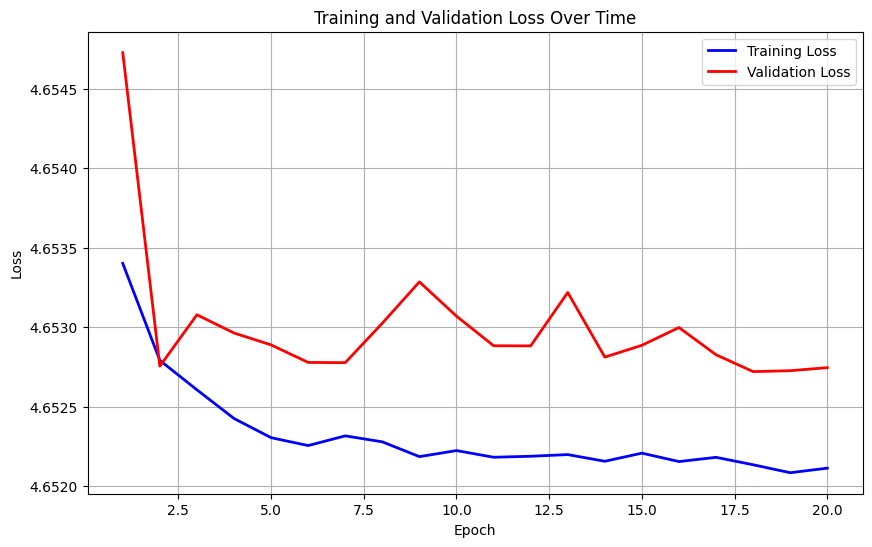

In [2]:

# Define the function
def f(x1, x2):
    return 3 * np.cos(2 * np.pi * (x1**2 - x2**2))

# Set the parameters
lower_bound = -1
upper_bound = 1
n_samples = 1000

# Generate the data
x1_values = np.linspace(lower_bound, upper_bound, n_samples).reshape(n_samples, 1)
x2_values = np.linspace(lower_bound, upper_bound, n_samples).reshape(n_samples, 1)

# Get a meshgrid for x1 and x2 values
X1, X2 = np.meshgrid(x1_values, x2_values)

# Calculate y values using the function
y_values = f(X1, X2)

# Reshape the data for training
X = np.column_stack((X1.ravel(), X2.ravel()))
y = y_values.ravel()

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Assuming H1Layer, H2Layer, H3Layer, H4Layer, H5Layer, and TensorDecompositionLayer are pre-defined
def build_model(input_shape, filters):
    rank = 3
    input_layer = Input(shape=input_shape)
    x = input_layer


    # Using 'he_normal' initialization for the Dense layers
    x = Dense(filters, )(x)
    x = Activation("sigmoid")(x)
    x = Dense(filters, )(x)
    x = TensorDecompositionLayer(rank)(x)
    x = Activation("sigmoid")(x)
    x = Dense(filters, )(x)
    x = TensorDecompositionLayer(rank)(x)
    x = Activation("sigmoid")(x)
    x = Dense(filters, )(x)
    x = TensorDecompositionLayer(rank)(x)
    x = Activation("sigmoid")(x)
    x = Dense(filters, )(x)
    x = TensorDecompositionLayer(rank)(x)
    
    output_layer = Dense(1, )(x)
    model = Model(inputs=input_layer, outputs=output_layer)

    return model 


input_shape = (2,)
filters = 128
modelN4 = build_model(input_shape, filters)
optimizer = Adam(learning_rate=0.0001) # Reduce learning rate
modelN4.compile(optimizer=optimizer, loss='mse')

batch_size = 64
epochs = 20

history = modelN4.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_val, y_val),
                    callbacks=[callback])

val_loss = modelN4.evaluate(X_val, y_val, verbose=0)
print(f"Validation loss: {val_loss}")


import matplotlib.pyplot as plt
modelN4.summary()

# 1. Extract loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# 2. Determine the number of epochs
actual_epochs = len(train_loss)

# 3. Create a plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, actual_epochs + 1), train_loss, label='Training Loss', color='b', linewidth=2)
plt.plot(range(1, actual_epochs + 1), val_loss, label='Validation Loss', color='r', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.grid()
plt.show()

# 2 var tanh + tensor decomposition

2023-11-02 11:56:33.962975: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


Epoch 1/20


2023-11-02 11:56:33.978123: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-02 11:56:33.978308: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-02 11:56:33.980220: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

12500/12500 [==============================] - 38s 3ms/step - loss: 4.6535 - val_loss: 4.6538
Epoch 2/20
12500/12500 [==============================] - 36s 3ms/step - loss: 4.6525 - val_loss: 4.6528
Epoch 3/20
12500/12500 [==============================] - 36s 3ms/step - loss: 4.6524 - val_loss: 4.6530
Epoch 4/20
12500/12500 [==============================] - 36s 3ms/step - loss: 4.4673 - val_loss: 4.3507
Epoch 5/20
12500/12500 [==============================] - 36s 3ms/step - loss: 4.2553 - val_loss: 4.2139
Epoch 6/20
12500/12500 [==============================] - 37s 3ms/step - loss: 4.2316 - val_loss: 4.2179
Epoch 7/20
12500/12500 [==============================] - 35s 3ms/step - loss: 4.2066 - val_loss: 4.2003
Epoch 8/20
12500/12500 [==============================] - 36s 3ms/step - loss: 4.0873 - val_loss: 3.3264
Epoch 9/20
12500/12500 [==============================] - 36s 3ms/step - loss: 3.2050 - val_loss: 3.1756
Epoch 10/20
12500/12500 [==============================] - 36s 3ms

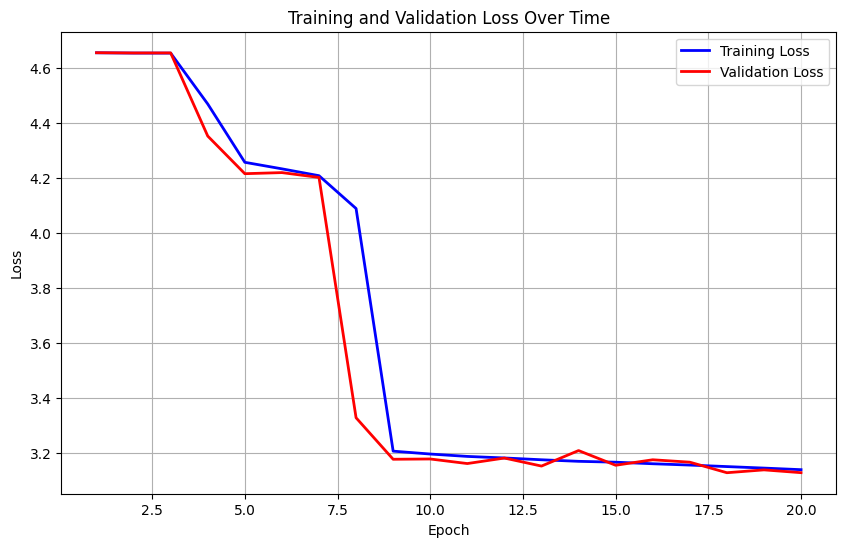

In [2]:

# Define the function
def f(x1, x2):
    return 3 * np.cos(2 * np.pi * (x1**2 - x2**2))

# Set the parameters
lower_bound = -1
upper_bound = 1
n_samples = 1000

# Generate the data
x1_values = np.linspace(lower_bound, upper_bound, n_samples).reshape(n_samples, 1)
x2_values = np.linspace(lower_bound, upper_bound, n_samples).reshape(n_samples, 1)

# Get a meshgrid for x1 and x2 values
X1, X2 = np.meshgrid(x1_values, x2_values)

# Calculate y values using the function
y_values = f(X1, X2)

# Reshape the data for training
X = np.column_stack((X1.ravel(), X2.ravel()))
y = y_values.ravel()

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Assuming H1Layer, H2Layer, H3Layer, H4Layer, H5Layer, and TensorDecompositionLayer are pre-defined
def build_model(input_shape, filters):
    rank = 3
    input_layer = Input(shape=input_shape)
    x = input_layer


    # Using 'he_normal' initialization for the Dense layers
    x = Dense(filters, )(x)
    x = Activation("tanh")(x)
    x = Dense(filters, )(x)
    x = TensorDecompositionLayer(rank)(x)
    x = Activation("tanh")(x)
    x = Dense(filters, )(x)
    x = TensorDecompositionLayer(rank)(x)
    x = Activation("tanh")(x)
    x = Dense(filters, )(x)
    x = TensorDecompositionLayer(rank)(x)
    x = Activation("tanh")(x)
    x = Dense(filters, )(x)
    x = TensorDecompositionLayer(rank)(x)
    
    output_layer = Dense(1, )(x)
    model = Model(inputs=input_layer, outputs=output_layer)

    return model 


input_shape = (2,)
filters = 128
modelN4 = build_model(input_shape, filters)
optimizer = Adam(learning_rate=0.0001) # Reduce learning rate
modelN4.compile(optimizer=optimizer, loss='mse')

batch_size = 64
epochs = 20

history = modelN4.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_val, y_val),
                    callbacks=[callback])

val_loss = modelN4.evaluate(X_val, y_val, verbose=0)
print(f"Validation loss: {val_loss}")

import matplotlib.pyplot as plt
modelN4.summary()

# 1. Extract loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# 2. Determine the number of epochs
actual_epochs = len(train_loss)

# 3. Create a plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, actual_epochs + 1), train_loss, label='Training Loss', color='b', linewidth=2)
plt.plot(range(1, actual_epochs + 1), val_loss, label='Validation Loss', color='r', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.grid()
plt.show()


2023-11-13 16:30:25.816963: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-13 16:30:26.266991: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-11-13 16:30:27.182313: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


Epoch 1/100


2023-11-13 16:30:27.199259: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-13 16:30:27.199440: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-13 16:30:27.201360: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

31250/31250 [==============================] - 47s 1ms/step - loss: 0.1982
Epoch 2/100
31250/31250 [==============================] - 45s 1ms/step - loss: 0.0054
Epoch 3/100
31250/31250 [==============================] - 45s 1ms/step - loss: 0.0048
Epoch 4/100
31250/31250 [==============================] - 46s 1ms/step - loss: 0.0042
Epoch 5/100
31250/31250 [==============================] - 46s 1ms/step - loss: 0.0031
Epoch 6/100
31250/31250 [==============================] - 46s 1ms/step - loss: 0.0022
Epoch 7/100
31250/31250 [==============================] - 45s 1ms/step - loss: 0.0019
Epoch 8/100
31250/31250 [==============================] - 45s 1ms/step - loss: 0.0018
Epoch 9/100
31250/31250 [==============================] - 46s 1ms/step - loss: 0.0017
Epoch 10/100
31250/31250 [==============================] - 45s 1ms/step - loss: 0.0016
Epoch 11/100
31250/31250 [==============================] - 45s 1ms/step - loss: 0.0016
Epoch 12/100
31250/31250 [===========================

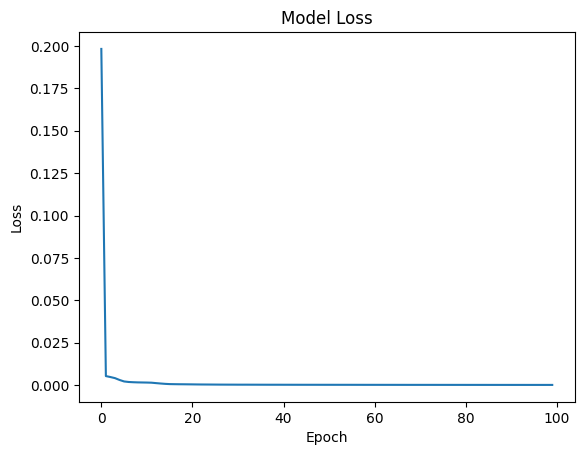

In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Function to be approximated
def target_function(x1, x2):
    return 3 * np.pi * np.cos(x1**2 - x2**2)

# Generating training data
sample_size = 1000
x1 = np.linspace(-1, 1, sample_size)
x2 = np.linspace(-1, 1, sample_size)

# Creating a meshgrid for combinations of x1 and x2
X1, X2 = np.meshgrid(x1, x2)
X = np.column_stack((X1.ravel(), X2.ravel()))
Y = target_function(X[:, 0], X[:, 1])

# Defining the neural network
model = Sequential()
model.add(Dense(64, input_dim=2, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='relu'))

# Compiling the model
model.compile(loss="mse", optimizer='adam')

# Training the model
history = model.fit(X, Y, epochs=100, batch_size=32, verbose=1)

# Plotting the training loss
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()


# OUR METHOD Single Variable Prediction Concat and Prediction

In [3]:

# Define the function
def f(x1, x2):
    return 3 * np.cos(2 * np.pi * (x1**2 - x2**2))

# Set the parameters
lower_bound = -1
upper_bound = 1
n_samples = 1000

# Generate the data
x1_values = np.linspace(lower_bound, upper_bound, n_samples).reshape(n_samples, 1)
x2_values = np.linspace(lower_bound, upper_bound, n_samples).reshape(n_samples, 1)

# Get a meshgrid for x1 and x2 values
X1, X2 = np.meshgrid(x1_values, x2_values)

# Calculate y values using the function
y_values = f(X1, X2)

# # Reshape the data for training
# X = np.column_stack((X1.ravel(), X2.ravel()))
# y = y_values.ravel()

# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Flatten the data for training
X1_flat = X1.ravel().reshape(-1, 1)  # Reshaped as a 2D array for model input
X2_flat = X2.ravel().reshape(-1, 1)  # Reshaped as a 2D array for model input
y_flat = y_values.ravel()

# Split the data into training and validation sets
X1_train, X1_val, X2_train, X2_val, y_train, y_val = train_test_split(X1_flat, X2_flat, y_flat, test_size=0.2, random_state=42)


# Assuming H1Layer, H2Layer, H3Layer, H4Layer, H5Layer, and TensorDecompositionLayer are pre-defined
def build_model(input_shape, filters):

    rank = 4
    input_x1 = Input(shape=(1,))
    input_x2 = Input(shape=(1,))

    h1 = H1Layer()
    h2 = H2Layer(h1)
    h3 = H3Layer(h1,h2)
    h4 = H4Layer(h2,h3)
    h5 = H5Layer(h3,h4)
    #Branch 1
    branch_x1 = Dense(filters)(input_x1)
    branch_x1 = Dense(filters)(branch_x1)

    #Branch 2
    branch_x2 = Dense(filters)(input_x2)
    branch_x2 = Dense(filters)(branch_x2)

    #Merge
    merged = concatenate([branch_x1, branch_x2])
    merged = Dense(filters)(merged)
    merged = h2(merged)
    merged = Dense(filters)(merged)
    merged = TensorDecompositionLayer(rank)(merged)
    merged = h3(merged)
    merged = Dense(filters)(merged)
    merged = TensorDecompositionLayer(rank)(merged)
    merged = h4(merged)
    merged = Dense(filters)(merged)
    merged = TensorDecompositionLayer(rank)(merged)

    output = Dense(1)(merged)  # Single output for your function
    model = Model(inputs=[input_x1, input_x2], outputs=output)

    return model 


input_shape = (2,)
filters = 128
modelN4 = build_model(input_shape, filters)
optimizer = Adam(learning_rate=0.0001) # Reduce learning rate
modelN4.compile(optimizer=optimizer, loss='mse')

batch_size = 128
epochs = 20

# history = modelN4.fit([X1_train], y_train,
#                     batch_size=batch_size,
#                     epochs=epochs,
#                     verbose=1,
#                     validation_data=(X_val, y_val),
#                     callbacks=[callback])

history = modelN4.fit([X1_train, X2_train], y_train,
                      batch_size=batch_size,
                      epochs=epochs,
                      verbose=1,
                      validation_data=([X1_val, X2_val], y_val),
                      callbacks=[callback])


val_loss = modelN4.evaluate([X1_val, X2_val], y_val, verbose=0)
print(f"Validation loss: {val_loss}")

import matplotlib.pyplot as plt
modelN4.summary()

# 1. Extract loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# 2. Determine the number of epochs
actual_epochs = len(train_loss)

# 3. Create a plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, actual_epochs + 1), train_loss, label='Training Loss', color='b', linewidth=2)
plt.plot(range(1, actual_epochs + 1), val_loss, label='Validation Loss', color='r', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.grid()
plt.show()

2023-11-14 15:29:53.967526: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-14 15:29:53.983486: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-14 15:29:53.983670: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Epoch 1/20


2023-11-14 15:29:56.397134: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-11-14 15:29:56.399839: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7efd8c074ab0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-14 15:29:56.399865: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2023-11-14 15:29:56.405853: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-14 15:29:56.515327: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-11-14 15:29:56.607272: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.

6250/6250 [==============================] - 27s 4ms/step - loss: 3.0608 - val_loss: 1.7396
Epoch 2/20
6250/6250 [==============================] - 24s 4ms/step - loss: 1.1871 - val_loss: 1.1892
Epoch 3/20
6250/6250 [==============================] - 23s 4ms/step - loss: 0.9742 - val_loss: 0.8002
Epoch 4/20
6250/6250 [==============================] - 24s 4ms/step - loss: 0.7027 - val_loss: 0.4694
Epoch 5/20
6250/6250 [==============================] - 24s 4ms/step - loss: 0.2066 - val_loss: 0.1500
Epoch 6/20
6250/6250 [==============================] - 23s 4ms/step - loss: 0.2396 - val_loss: 0.0921
Epoch 7/20
6250/6250 [==============================] - 23s 4ms/step - loss: 0.1170 - val_loss: 0.1083
Epoch 8/20
6250/6250 [==============================] - 24s 4ms/step - loss: 0.1032 - val_loss: 0.1700
Epoch 9/20
6250/6250 [==============================] - 23s 4ms/step - loss: 0.5653 - val_loss: 0.0814
Epoch 10/20
6250/6250 [==============================] - 23s 4ms/step - loss: 0.2354

Validation loss: 0.0007427032687701285
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 dense (Dense)               (None, 128)                  256       ['input_1[0][0]']             
                                                                                                  
 dense_2 (Dense)             (None, 128)                  256       ['input_2[0][0]']             
                                                       

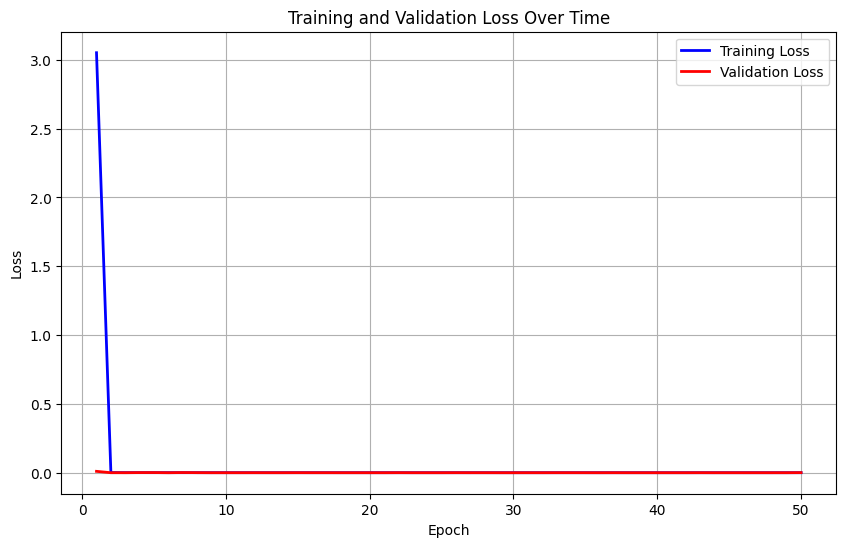

In [3]:

val_loss = modelN4.evaluate([X1_val, X2_val], y_val, verbose=0)
print(f"Validation loss: {val_loss}")

import matplotlib.pyplot as plt
modelN4.summary()

# 1. Extract loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# 2. Determine the number of epochs
actual_epochs = len(train_loss)

# 3. Create a plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, actual_epochs + 1), train_loss, label='Training Loss', color='b', linewidth=2)
plt.plot(range(1, actual_epochs + 1), val_loss, label='Validation Loss', color='r', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.grid()
plt.show()

# Function f(x1,x2) = 3*sin*(pi*x1)* cos*(pi*x2)*cos*(pi^2*x1*x2)

2023-11-16 12:26:10.814959: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-16 12:26:10.831599: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-16 12:26:10.831785: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Epoch 1/20


2023-11-16 12:26:13.207504: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-11-16 12:26:13.209056: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f9a2f037980 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-16 12:26:13.209067: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2023-11-16 12:26:13.212136: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-16 12:26:13.315800: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-11-16 12:26:13.403441: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.

6250/6250 [==============================] - 27s 4ms/step - loss: 0.4609 - val_loss: 0.0922
Epoch 2/20
6250/6250 [==============================] - 24s 4ms/step - loss: 0.0492 - val_loss: 0.0342
Epoch 3/20
6250/6250 [==============================] - 24s 4ms/step - loss: 0.0230 - val_loss: 0.0107
Epoch 4/20
6250/6250 [==============================] - 23s 4ms/step - loss: 0.0069 - val_loss: 0.0025
Epoch 5/20
6250/6250 [==============================] - 23s 4ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 6/20
6250/6250 [==============================] - 23s 4ms/step - loss: 0.0024 - val_loss: 0.0017
Epoch 7/20
6250/6250 [==============================] - 24s 4ms/step - loss: 0.0017 - val_loss: 0.0020
Epoch 8/20
6250/6250 [==============================] - 23s 4ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 9/20
6250/6250 [==============================] - 23s 4ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 10/20
6243/6250 [============================>.] - ETA: 0s - loss: 0.0013
Stop

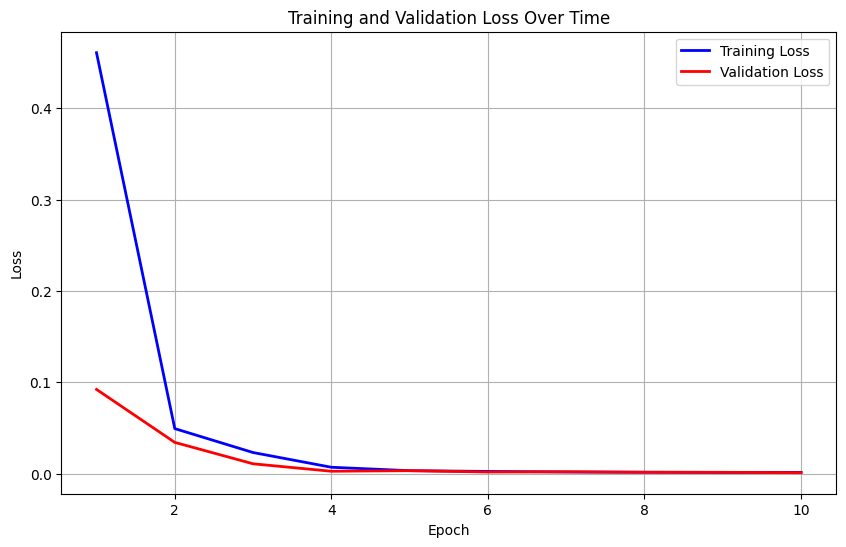

In [2]:

# Define the function
def f(x1, x2):
    return 3 * np.sin(np.pi*x1)*np.cos(np.pi*x2)*np.cos(np.pi**2 *x1*x2)

# Set the parameters
lower_bound = -1
upper_bound = 1
n_samples = 1000

# Generate the data
x1_values = np.linspace(lower_bound, upper_bound, n_samples).reshape(n_samples, 1)
x2_values = np.linspace(lower_bound, upper_bound, n_samples).reshape(n_samples, 1)

# Get a meshgrid for x1 and x2 values
X1, X2 = np.meshgrid(x1_values, x2_values)

# Calculate y values using the function
y_values = f(X1, X2)

# # Reshape the data for training
# X = np.column_stack((X1.ravel(), X2.ravel()))
# y = y_values.ravel()

# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Flatten the data for training
X1_flat = X1.ravel().reshape(-1, 1)  # Reshaped as a 2D array for model input
X2_flat = X2.ravel().reshape(-1, 1)  # Reshaped as a 2D array for model input
y_flat = y_values.ravel()

# Split the data into training and validation sets
X1_train, X1_val, X2_train, X2_val, y_train, y_val = train_test_split(X1_flat, X2_flat, y_flat, test_size=0.2, random_state=42)


# Assuming H1Layer, H2Layer, H3Layer, H4Layer, H5Layer, and TensorDecompositionLayer are pre-defined
def build_model(input_shape, filters):

    rank = 4
    input_x1 = Input(shape=(1,))
    input_x2 = Input(shape=(1,))

    h1 = H1Layer()
    h2 = H2Layer(h1)
    h3 = H3Layer(h1,h2)
    h4 = H4Layer(h2,h3)
    h5 = H5Layer(h3,h4)
    #Branch 1
    branch_x1 = Dense(filters)(input_x1)
    branch_x1 = Dense(filters)(branch_x1)

    #Branch 2
    branch_x2 = Dense(filters)(input_x2)
    branch_x2 = Dense(filters)(branch_x2)

    #Merge
    merged = concatenate([branch_x1, branch_x2])
    merged = Dense(filters)(merged)
    merged = h2(merged)
    merged = Dense(filters)(merged)
    merged = TensorDecompositionLayer(rank)(merged)
    merged = h3(merged)
    merged = Dense(filters)(merged)
    merged = TensorDecompositionLayer(rank)(merged)
    merged = h4(merged)
    merged = Dense(filters)(merged)
    merged = TensorDecompositionLayer(rank)(merged)

    output = Dense(1)(merged)  # Single output for your function
    model = Model(inputs=[input_x1, input_x2], outputs=output)

    return model 


input_shape = (2,)
filters = 128
modelN4 = build_model(input_shape, filters)
optimizer = Adam(learning_rate=0.0001) # Reduce learning rate
modelN4.compile(optimizer=optimizer, loss='mse')

batch_size = 128
epochs = 20

# history = modelN4.fit([X1_train], y_train,
#                     batch_size=batch_size,
#                     epochs=epochs,
#                     verbose=1,
#                     validation_data=(X_val, y_val),
#                     callbacks=[callback])

history = modelN4.fit([X1_train, X2_train], y_train,
                      batch_size=batch_size,
                      epochs=epochs,
                      verbose=1,
                      validation_data=([X1_val, X2_val], y_val),
                      callbacks=[callback])


val_loss = modelN4.evaluate([X1_val, X2_val], y_val, verbose=0)
print(f"Validation loss: {val_loss}")

import matplotlib.pyplot as plt
modelN4.summary()

# 1. Extract loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# 2. Determine the number of epochs
actual_epochs = len(train_loss)

# 3. Create a plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, actual_epochs + 1), train_loss, label='Training Loss', color='b', linewidth=2)
plt.plot(range(1, actual_epochs + 1), val_loss, label='Validation Loss', color='r', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.grid()
plt.show()

313/313 [==============================] - 0s 1ms/step


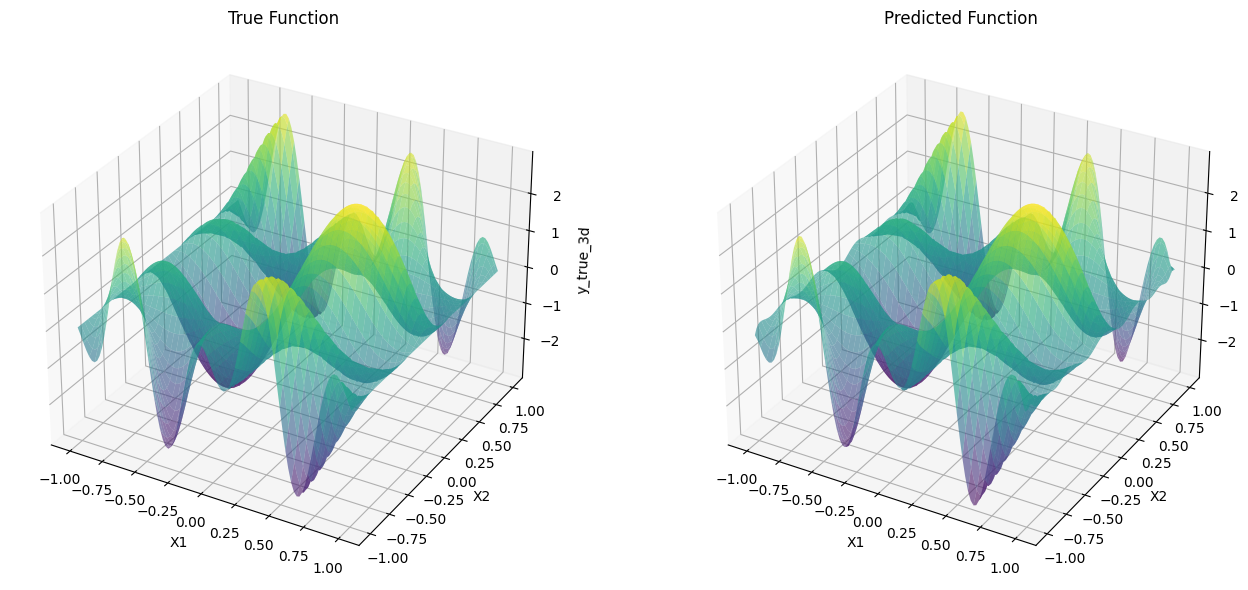

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Define the function
def f(x1, x2):
    return 3 * np.sin(np.pi * x1) * np.cos(np.pi * x2) * np.cos(np.pi**2 * x1 * x2)

# Set parameters
lower_bound = -1
upper_bound = 1
num_test_samples = 100

# Generate test data
x1_test_values = np.linspace(lower_bound, upper_bound, num=num_test_samples).reshape(-1, 1)
x2_test_values = np.linspace(lower_bound, upper_bound, num=num_test_samples).reshape(-1, 1)

# Get a meshgrid for x1 and x2 test values
X1_test, X2_test = np.meshgrid(x1_test_values, x2_test_values)

X1_flat = X1_test.ravel().reshape(-1, 1)  # Reshaped as a 2D array for model input
X2_flat = X2_test.ravel().reshape(-1, 1)  # Reshaped as a 2D array for model input

# Calculate y true values using the function
y_true_3d = f(X1_test, X2_test)

# Placeholder for predicted values (since we don't have the actual model to predict)
y_pred_3d = modelN4.predict([X1_flat,X2_flat])

# Reshape the predicted y values to match the shape of X1_test and X2_test
y_pred_3d_reshaped = y_pred_3d.reshape(X1_test.shape)

# 3D visualization of the data with real and predicted values
fig = plt.figure(figsize=(14, 6))

# True values subplot
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(X1_test, X2_test, y_true_3d, cmap='viridis', alpha=0.6)
ax1.set_xlabel('X1')
ax1.set_ylabel('X2')
ax1.set_zlabel('y_true_3d')
ax1.set_title('True Function')
ax1.grid(True)

# Predicted values subplot
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(X1_test, X2_test, y_pred_3d_reshaped, cmap='viridis', alpha=0.6)
ax2.set_xlabel('X1')
ax2.set_ylabel('X2')
ax2.set_zlabel('y_pred_3d')
ax2.set_title('Predicted Function')
ax2.grid(True)

plt.tight_layout()
plt.show()


# RELU
# Function f(x1,x2) = 3*sin*(pi*x1)* cos*(pi*x2)*cos*(pi^2*x1*x2)

2023-11-16 13:10:12.459797: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


Epoch 1/20


2023-11-16 13:10:12.476572: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-16 13:10:12.476981: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-16 13:10:12.478790: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

6250/6250 [==============================] - 23s 3ms/step - loss: 0.2609 - val_loss: 0.0122
Epoch 2/20
6250/6250 [==============================] - 20s 3ms/step - loss: 0.0090 - val_loss: 0.0064
Epoch 3/20
6250/6250 [==============================] - 20s 3ms/step - loss: 0.0056 - val_loss: 0.0043
Epoch 4/20
6250/6250 [==============================] - 20s 3ms/step - loss: 0.0042 - val_loss: 0.0037
Epoch 5/20
6250/6250 [==============================] - 20s 3ms/step - loss: 0.0035 - val_loss: 0.0030
Epoch 6/20
6250/6250 [==============================] - 20s 3ms/step - loss: 0.0031 - val_loss: 0.0026
Epoch 7/20
6250/6250 [==============================] - 20s 3ms/step - loss: 0.0029 - val_loss: 0.0017
Epoch 8/20
6250/6250 [==============================] - 20s 3ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 9/20
6250/6250 [==============================] - 20s 3ms/step - loss: 0.0025 - val_loss: 0.0040
Epoch 10/20
6250/6250 [==============================] - 20s 3ms/step - loss: 0.0024

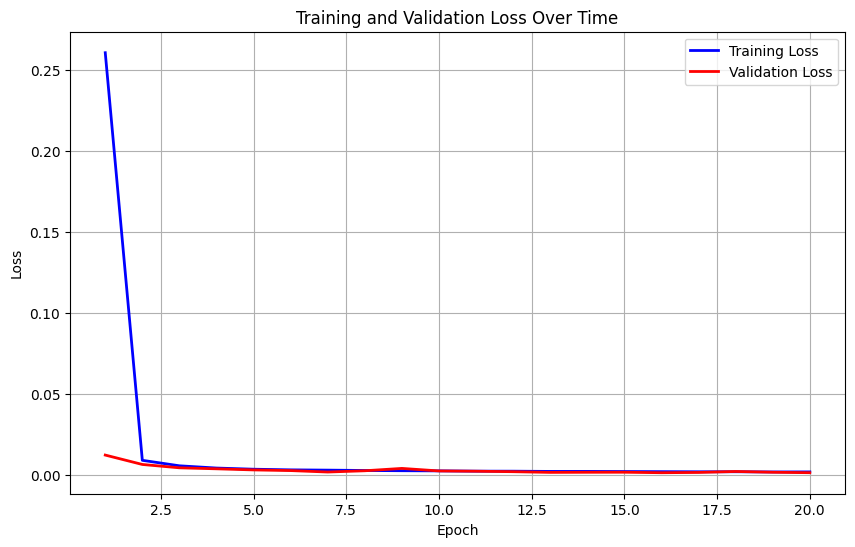

In [3]:

# Define the function
def f(x1, x2):
    return 3 * np.sin(np.pi*x1)*np.cos(np.pi*x2)*np.cos(np.pi**2 *x1*x2)

# Set the parameters
lower_bound = -1
upper_bound = 1
n_samples = 1000

# Generate the data
x1_values = np.linspace(lower_bound, upper_bound, n_samples).reshape(n_samples, 1)
x2_values = np.linspace(lower_bound, upper_bound, n_samples).reshape(n_samples, 1)

# Get a meshgrid for x1 and x2 values
X1, X2 = np.meshgrid(x1_values, x2_values)

# Calculate y values using the function
y_values = f(X1, X2)

# # Reshape the data for training
# X = np.column_stack((X1.ravel(), X2.ravel()))
# y = y_values.ravel()

# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Flatten the data for training
X1_flat = X1.ravel().reshape(-1, 1)  # Reshaped as a 2D array for model input
X2_flat = X2.ravel().reshape(-1, 1)  # Reshaped as a 2D array for model input
y_flat = y_values.ravel()

# Split the data into training and validation sets
X1_train, X1_val, X2_train, X2_val, y_train, y_val = train_test_split(X1_flat, X2_flat, y_flat, test_size=0.2, random_state=42)


# Assuming H1Layer, H2Layer, H3Layer, H4Layer, H5Layer, and TensorDecompositionLayer are pre-defined
def build_model(input_shape, filters):

    rank = 4
    input_x1 = Input(shape=(1,))
    input_x2 = Input(shape=(1,))

    modRelu = Relu_With_Weight()

    #Branch 1
    branch_x1 = Dense(filters)(input_x1)
    branch_x1 = Dense(filters)(branch_x1)

    #Branch 2
    branch_x2 = Dense(filters)(input_x2)
    branch_x2 = Dense(filters)(branch_x2)

    #Merge
    merged = concatenate([branch_x1, branch_x2])
    merged = Dense(filters)(merged)
    merged = modRelu(merged)
    merged = Dense(filters)(merged)
    merged = TensorDecompositionLayer(rank)(merged)
    merged = Activation("relu")(merged)
    merged = Dense(filters)(merged)
    merged = TensorDecompositionLayer(rank)(merged)
    merged = Activation("relu")(merged)
    merged = Dense(filters)(merged)
    merged = TensorDecompositionLayer(rank)(merged)

    output = Dense(1)(merged)  # Single output for your function
    model = Model(inputs=[input_x1, input_x2], outputs=output)

    return model 


input_shape = (2,)
filters = 128
modelN4 = build_model(input_shape, filters)
optimizer = Adam(learning_rate=0.0001) # Reduce learning rate
modelN4.compile(optimizer=optimizer, loss='mse')

batch_size = 128
epochs = 20

# history = modelN4.fit([X1_train], y_train,
#                     batch_size=batch_size,
#                     epochs=epochs,
#                     verbose=1,
#                     validation_data=(X_val, y_val),
#                     callbacks=[callback])

history = modelN4.fit([X1_train, X2_train], y_train,
                      batch_size=batch_size,
                      epochs=epochs,
                      verbose=1,
                      validation_data=([X1_val, X2_val], y_val),
                      callbacks=[callback])


val_loss = modelN4.evaluate([X1_val, X2_val], y_val, verbose=0)
print(f"Validation loss: {val_loss}")

import matplotlib.pyplot as plt
modelN4.summary()

# 1. Extract loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# 2. Determine the number of epochs
actual_epochs = len(train_loss)

# 3. Create a plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, actual_epochs + 1), train_loss, label='Training Loss', color='b', linewidth=2)
plt.plot(range(1, actual_epochs + 1), val_loss, label='Validation Loss', color='r', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.grid()
plt.show()

# SIGMOID
# Function f(x1,x2) = 3*sin*(pi*x1)* cos*(pi*x2)*cos*(pi^2*x1*x2)

2023-11-16 13:19:47.138246: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


Epoch 1/20


2023-11-16 13:19:47.154889: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-16 13:19:47.155072: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-16 13:19:47.157004: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

6250/6250 [==============================] - 24s 3ms/step - loss: 1.2535 - val_loss: 1.2461
Epoch 2/20
6250/6250 [==============================] - 21s 3ms/step - loss: 1.2535 - val_loss: 1.2461
Epoch 3/20
6250/6250 [==============================] - 21s 3ms/step - loss: 1.2535 - val_loss: 1.2461
Epoch 4/20
6250/6250 [==============================] - 21s 3ms/step - loss: 1.2535 - val_loss: 1.2461
Epoch 5/20
6250/6250 [==============================] - 21s 3ms/step - loss: 1.2535 - val_loss: 1.2461
Epoch 6/20
6250/6250 [==============================] - 21s 3ms/step - loss: 1.2535 - val_loss: 1.2461
Epoch 7/20
6250/6250 [==============================] - 21s 3ms/step - loss: 1.2535 - val_loss: 1.2461
Epoch 8/20
6250/6250 [==============================] - 21s 3ms/step - loss: 1.2535 - val_loss: 1.2461
Epoch 9/20
6250/6250 [==============================] - 21s 3ms/step - loss: 1.2535 - val_loss: 1.2461
Epoch 10/20
6250/6250 [==============================] - 21s 3ms/step - loss: 1.2535

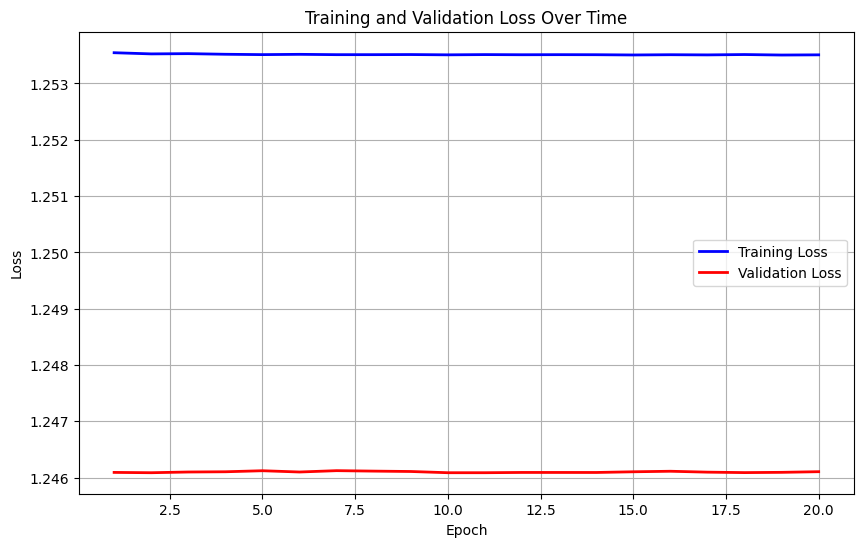

In [2]:

# Define the function
def f(x1, x2):
    return 3 * np.sin(np.pi*x1)*np.cos(np.pi*x2)*np.cos(np.pi**2 *x1*x2)

# Set the parameters
lower_bound = -1
upper_bound = 1
n_samples = 1000

# Generate the data
x1_values = np.linspace(lower_bound, upper_bound, n_samples).reshape(n_samples, 1)
x2_values = np.linspace(lower_bound, upper_bound, n_samples).reshape(n_samples, 1)

# Get a meshgrid for x1 and x2 values
X1, X2 = np.meshgrid(x1_values, x2_values)

# Calculate y values using the function
y_values = f(X1, X2)

# # Reshape the data for training
# X = np.column_stack((X1.ravel(), X2.ravel()))
# y = y_values.ravel()

# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Flatten the data for training
X1_flat = X1.ravel().reshape(-1, 1)  # Reshaped as a 2D array for model input
X2_flat = X2.ravel().reshape(-1, 1)  # Reshaped as a 2D array for model input
y_flat = y_values.ravel()

# Split the data into training and validation sets
X1_train, X1_val, X2_train, X2_val, y_train, y_val = train_test_split(X1_flat, X2_flat, y_flat, test_size=0.2, random_state=42)


# Assuming H1Layer, H2Layer, H3Layer, H4Layer, H5Layer, and TensorDecompositionLayer are pre-defined
def build_model(input_shape, filters):

    rank = 4
    input_x1 = Input(shape=(1,))
    input_x2 = Input(shape=(1,))

    modRelu = Relu_With_Weight()

    #Branch 1
    branch_x1 = Dense(filters)(input_x1)
    branch_x1 = Dense(filters)(branch_x1)

    #Branch 2
    branch_x2 = Dense(filters)(input_x2)
    branch_x2 = Dense(filters)(branch_x2)

    #Merge
    merged = concatenate([branch_x1, branch_x2])
    merged = Dense(filters)(merged)
    merged = modRelu(merged)
    merged = Dense(filters)(merged)
    merged = TensorDecompositionLayer(rank)(merged)
    merged = Activation("sigmoid")(merged)
    merged = Dense(filters)(merged)
    merged = TensorDecompositionLayer(rank)(merged)
    merged = Activation("sigmoid")(merged)
    merged = Dense(filters)(merged)
    merged = TensorDecompositionLayer(rank)(merged)

    output = Dense(1)(merged)  # Single output for your function
    model = Model(inputs=[input_x1, input_x2], outputs=output)

    return model 


input_shape = (2,)
filters = 128
modelN4 = build_model(input_shape, filters)
optimizer = Adam(learning_rate=0.0001) # Reduce learning rate
modelN4.compile(optimizer=optimizer, loss='mse')

batch_size = 128
epochs = 20

# history = modelN4.fit([X1_train], y_train,
#                     batch_size=batch_size,
#                     epochs=epochs,
#                     verbose=1,
#                     validation_data=(X_val, y_val),
#                     callbacks=[callback])

history = modelN4.fit([X1_train, X2_train], y_train,
                      batch_size=batch_size,
                      epochs=epochs,
                      verbose=1,
                      validation_data=([X1_val, X2_val], y_val),
                      callbacks=[callback])


val_loss = modelN4.evaluate([X1_val, X2_val], y_val, verbose=0)
print(f"Validation loss: {val_loss}")

import matplotlib.pyplot as plt
modelN4.summary()

# 1. Extract loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# 2. Determine the number of epochs
actual_epochs = len(train_loss)

# 3. Create a plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, actual_epochs + 1), train_loss, label='Training Loss', color='b', linewidth=2)
plt.plot(range(1, actual_epochs + 1), val_loss, label='Validation Loss', color='r', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.grid()
plt.show()

# TANH
# Function f(x1,x2) = 3*sin*(pi*x1)* cos*(pi*x2)*cos*(pi^2*x1*x2)

2023-11-16 13:28:06.162277: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


Epoch 1/20


2023-11-16 13:28:06.179298: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-16 13:28:06.179482: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-16 13:28:06.181213: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

6250/6250 [==============================] - 24s 3ms/step - loss: 1.0606 - val_loss: 0.8892
Epoch 2/20
6250/6250 [==============================] - 21s 3ms/step - loss: 0.8907 - val_loss: 0.8799
Epoch 3/20
6250/6250 [==============================] - 21s 3ms/step - loss: 0.8797 - val_loss: 0.8703
Epoch 4/20
6250/6250 [==============================] - 21s 3ms/step - loss: 0.8657 - val_loss: 0.8640
Epoch 5/20
6250/6250 [==============================] - 21s 3ms/step - loss: 0.8607 - val_loss: 0.8548
Epoch 6/20
6250/6250 [==============================] - 21s 3ms/step - loss: 0.8586 - val_loss: 0.8496
Epoch 7/20
6250/6250 [==============================] - 21s 3ms/step - loss: 0.8576 - val_loss: 0.8459
Epoch 8/20
6250/6250 [==============================] - 21s 3ms/step - loss: 0.8563 - val_loss: 0.8444
Epoch 9/20
6250/6250 [==============================] - 21s 3ms/step - loss: 0.8547 - val_loss: 0.8450
Epoch 10/20
6250/6250 [==============================] - 21s 3ms/step - loss: 0.8543

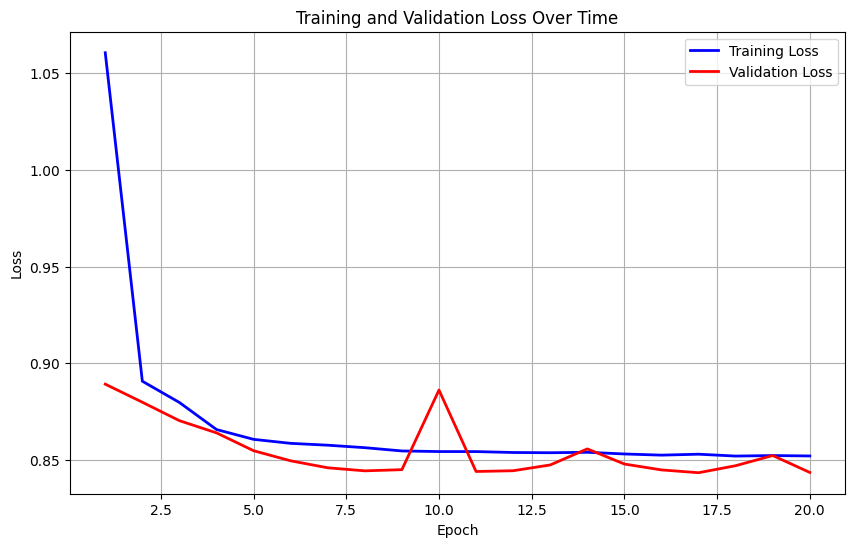

In [2]:

# Define the function
def f(x1, x2):
    return 3 * np.sin(np.pi*x1)*np.cos(np.pi*x2)*np.cos(np.pi**2 *x1*x2)

# Set the parameters
lower_bound = -1
upper_bound = 1
n_samples = 1000

# Generate the data
x1_values = np.linspace(lower_bound, upper_bound, n_samples).reshape(n_samples, 1)
x2_values = np.linspace(lower_bound, upper_bound, n_samples).reshape(n_samples, 1)

# Get a meshgrid for x1 and x2 values
X1, X2 = np.meshgrid(x1_values, x2_values)

# Calculate y values using the function
y_values = f(X1, X2)

# # Reshape the data for training
# X = np.column_stack((X1.ravel(), X2.ravel()))
# y = y_values.ravel()

# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Flatten the data for training
X1_flat = X1.ravel().reshape(-1, 1)  # Reshaped as a 2D array for model input
X2_flat = X2.ravel().reshape(-1, 1)  # Reshaped as a 2D array for model input
y_flat = y_values.ravel()

# Split the data into training and validation sets
X1_train, X1_val, X2_train, X2_val, y_train, y_val = train_test_split(X1_flat, X2_flat, y_flat, test_size=0.2, random_state=42)


# Assuming H1Layer, H2Layer, H3Layer, H4Layer, H5Layer, and TensorDecompositionLayer are pre-defined
def build_model(input_shape, filters):

    rank = 4
    input_x1 = Input(shape=(1,))
    input_x2 = Input(shape=(1,))

    modRelu = Relu_With_Weight()

    #Branch 1
    branch_x1 = Dense(filters)(input_x1)
    branch_x1 = Dense(filters)(branch_x1)

    #Branch 2
    branch_x2 = Dense(filters)(input_x2)
    branch_x2 = Dense(filters)(branch_x2)

    #Merge
    merged = concatenate([branch_x1, branch_x2])
    merged = Dense(filters)(merged)
    merged = modRelu(merged)
    merged = Dense(filters)(merged)
    merged = TensorDecompositionLayer(rank)(merged)
    merged = Activation("tanh")(merged)
    merged = Dense(filters)(merged)
    merged = TensorDecompositionLayer(rank)(merged)
    merged = Activation("tanh")(merged)
    merged = Dense(filters)(merged)
    merged = TensorDecompositionLayer(rank)(merged)

    output = Dense(1)(merged)  # Single output for your function
    model = Model(inputs=[input_x1, input_x2], outputs=output)

    return model 


input_shape = (2,)
filters = 128
modelN4 = build_model(input_shape, filters)
optimizer = Adam(learning_rate=0.0001) # Reduce learning rate
modelN4.compile(optimizer=optimizer, loss='mse')

batch_size = 128
epochs = 20

# history = modelN4.fit([X1_train], y_train,
#                     batch_size=batch_size,
#                     epochs=epochs,
#                     verbose=1,
#                     validation_data=(X_val, y_val),
#                     callbacks=[callback])

history = modelN4.fit([X1_train, X2_train], y_train,
                      batch_size=batch_size,
                      epochs=epochs,
                      verbose=1,
                      validation_data=([X1_val, X2_val], y_val),
                      callbacks=[callback])


val_loss = modelN4.evaluate([X1_val, X2_val], y_val, verbose=0)
print(f"Validation loss: {val_loss}")

import matplotlib.pyplot as plt
modelN4.summary()

# 1. Extract loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# 2. Determine the number of epochs
actual_epochs = len(train_loss)

# 3. Create a plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, actual_epochs + 1), train_loss, label='Training Loss', color='b', linewidth=2)
plt.plot(range(1, actual_epochs + 1), val_loss, label='Validation Loss', color='r', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.grid()
plt.show()

# New arch 2 variables no tensor decomposition, No weight for input
# RELU

2023-11-16 15:22:35.206676: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


Epoch 1/20


2023-11-16 15:22:35.223952: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-16 15:22:35.224139: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-16 15:22:35.225906: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

6250/6250 [==============================] - 20s 3ms/step - loss: 0.1457 - val_loss: 0.0106
Epoch 2/20
6250/6250 [==============================] - 17s 3ms/step - loss: 0.0082 - val_loss: 0.0065
Epoch 3/20
6250/6250 [==============================] - 17s 3ms/step - loss: 0.0059 - val_loss: 0.0098
Epoch 4/20
6250/6250 [==============================] - 17s 3ms/step - loss: 0.0046 - val_loss: 0.0059
Epoch 5/20
6250/6250 [==============================] - 17s 3ms/step - loss: 0.0035 - val_loss: 0.0028
Epoch 6/20
6250/6250 [==============================] - 17s 3ms/step - loss: 0.0029 - val_loss: 0.0014
Epoch 7/20
6250/6250 [==============================] - 17s 3ms/step - loss: 0.0023 - val_loss: 0.0028
Epoch 8/20
6250/6250 [==============================] - 17s 3ms/step - loss: 0.0021 - val_loss: 0.0014
Epoch 9/20
6250/6250 [==============================] - 17s 3ms/step - loss: 0.0019 - val_loss: 0.0028
Epoch 10/20
6250/6250 [==============================] - 18s 3ms/step - loss: 0.0017

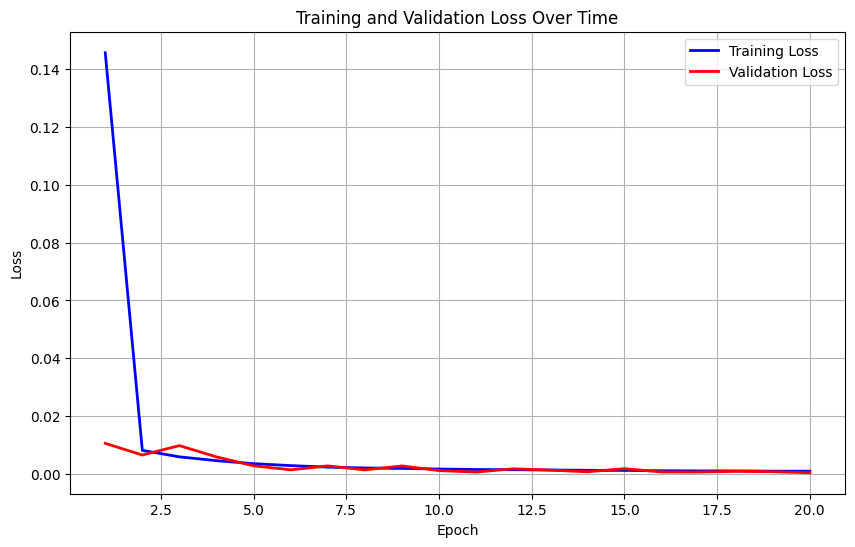

In [2]:
 
# Define the function
def f(x1, x2):
    return 3 * np.sin(np.pi*x1)*np.cos(np.pi*x2)*np.cos(np.pi**2 *x1*x2)

# Set the parameters
lower_bound = -1
upper_bound = 1
n_samples = 1000

# Generate the data
x1_values = np.linspace(lower_bound, upper_bound, n_samples).reshape(n_samples, 1)
x2_values = np.linspace(lower_bound, upper_bound, n_samples).reshape(n_samples, 1)

# Get a meshgrid for x1 and x2 values
X1, X2 = np.meshgrid(x1_values, x2_values)

# Calculate y values using the function
y_values = f(X1, X2)

# # Reshape the data for training
# X = np.column_stack((X1.ravel(), X2.ravel()))
# y = y_values.ravel()

# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Flatten the data for training
X1_flat = X1.ravel().reshape(-1, 1)  # Reshaped as a 2D array for model input
X2_flat = X2.ravel().reshape(-1, 1)  # Reshaped as a 2D array for model input
y_flat = y_values.ravel()

# Split the data into training and validation sets
X1_train, X1_val, X2_train, X2_val, y_train, y_val = train_test_split(X1_flat, X2_flat, y_flat, test_size=0.2, random_state=42)


# Assuming H1Layer, H2Layer, H3Layer, H4Layer, H5Layer, and TensorDecompositionLayer are pre-defined
def build_model(input_shape, filters):

    rank = 4
    input_x1 = Input(shape=(1,))
    input_x2 = Input(shape=(1,))

    modRelu = Relu_With_Weight()

    #Branch 1
    branch_x1 = Dense(filters)(input_x1)
    branch_x1 = Dense(filters)(branch_x1)

    #Branch 2
    branch_x2 = Dense(filters)(input_x2)
    branch_x2 = Dense(filters)(branch_x2)

    #Merge
    merged = concatenate([branch_x1, branch_x2])
    merged = Dense(filters)(merged)
    merged = Activation("relu")(merged)
    merged = Dense(filters)(merged)
    merged = Activation("relu")(merged)
    merged = Dense(filters)(merged)
    merged = Activation("relu")(merged)
    merged = Dense(filters)(merged)

    output = Dense(1)(merged)  # Single output for your function
    model = Model(inputs=[input_x1, input_x2], outputs=output)

    return model 


input_shape = (2,)
filters = 128
modelN4 = build_model(input_shape, filters)
optimizer = Adam(learning_rate=0.0001) # Reduce learning rate
modelN4.compile(optimizer=optimizer, loss='mse')

batch_size = 128
epochs = 20

# history = modelN4.fit([X1_train], y_train,
#                     batch_size=batch_size,
#                     epochs=epochs,
#                     verbose=1,
#                     validation_data=(X_val, y_val),
#                     callbacks=[callback])

history = modelN4.fit([X1_train, X2_train], y_train,
                      batch_size=batch_size,
                      epochs=epochs,
                      verbose=1,
                      validation_data=([X1_val, X2_val], y_val),
                      callbacks=[callback])


val_loss = modelN4.evaluate([X1_val, X2_val], y_val, verbose=0)
print(f"Validation loss: {val_loss}")

import matplotlib.pyplot as plt
modelN4.summary()

# 1. Extract loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# 2. Determine the number of epochs
actual_epochs = len(train_loss)

# 3. Create a plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, actual_epochs + 1), train_loss, label='Training Loss', color='b', linewidth=2)
plt.plot(range(1, actual_epochs + 1), val_loss, label='Validation Loss', color='r', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.grid()
plt.show()

# New arch 2 variables no tensor decomposition, No weight for input
# SIGMOID

2023-11-16 15:44:46.618924: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


Epoch 1/20


2023-11-16 15:44:46.635106: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-16 15:44:46.635283: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-16 15:44:46.637327: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

6250/6250 [==============================] - 20s 3ms/step - loss: 0.7546 - val_loss: 0.4953
Epoch 2/20
6250/6250 [==============================] - 18s 3ms/step - loss: 0.4347 - val_loss: 0.3925
Epoch 3/20
6250/6250 [==============================] - 18s 3ms/step - loss: 0.3634 - val_loss: 0.3373
Epoch 4/20
6250/6250 [==============================] - 17s 3ms/step - loss: 0.3321 - val_loss: 0.3125
Epoch 5/20
6250/6250 [==============================] - 18s 3ms/step - loss: 0.3155 - val_loss: 0.2942
Epoch 6/20
6250/6250 [==============================] - 18s 3ms/step - loss: 0.3040 - val_loss: 0.2966
Epoch 7/20
6250/6250 [==============================] - 17s 3ms/step - loss: 0.2888 - val_loss: 0.2724
Epoch 8/20
6250/6250 [==============================] - 18s 3ms/step - loss: 0.2747 - val_loss: 0.2535
Epoch 9/20
6250/6250 [==============================] - 17s 3ms/step - loss: 0.2522 - val_loss: 0.2366
Epoch 10/20
6250/6250 [==============================] - 17s 3ms/step - loss: 0.2212

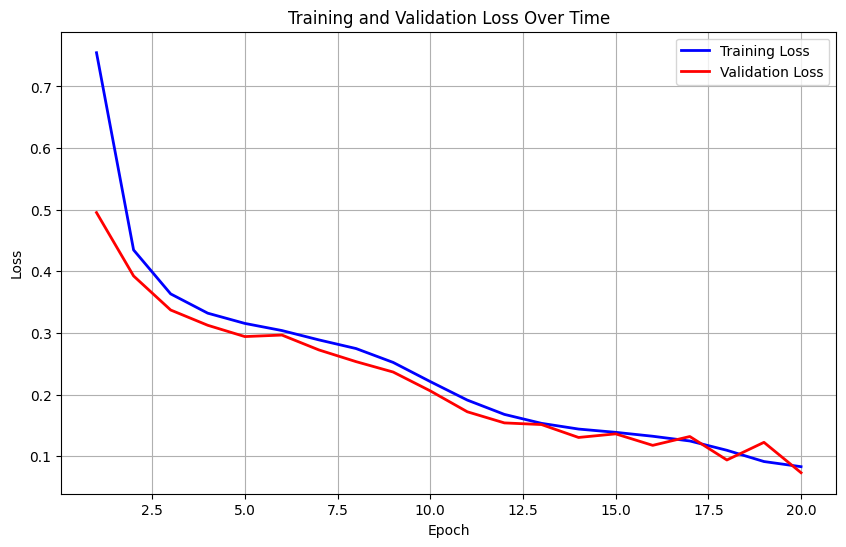

In [2]:
 
# Define the function
def f(x1, x2):
    return 3 * np.sin(np.pi*x1)*np.cos(np.pi*x2)*np.cos(np.pi**2 *x1*x2)

# Set the parameters
lower_bound = -1
upper_bound = 1
n_samples = 1000

# Generate the data
x1_values = np.linspace(lower_bound, upper_bound, n_samples).reshape(n_samples, 1)
x2_values = np.linspace(lower_bound, upper_bound, n_samples).reshape(n_samples, 1)

# Get a meshgrid for x1 and x2 values
X1, X2 = np.meshgrid(x1_values, x2_values)

# Calculate y values using the function
y_values = f(X1, X2)

# # Reshape the data for training
# X = np.column_stack((X1.ravel(), X2.ravel()))
# y = y_values.ravel()

# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Flatten the data for training
X1_flat = X1.ravel().reshape(-1, 1)  # Reshaped as a 2D array for model input
X2_flat = X2.ravel().reshape(-1, 1)  # Reshaped as a 2D array for model input
y_flat = y_values.ravel()

# Split the data into training and validation sets
X1_train, X1_val, X2_train, X2_val, y_train, y_val = train_test_split(X1_flat, X2_flat, y_flat, test_size=0.2, random_state=42)


# Assuming H1Layer, H2Layer, H3Layer, H4Layer, H5Layer, and TensorDecompositionLayer are pre-defined
def build_model(input_shape, filters):

    rank = 4
    input_x1 = Input(shape=(1,))
    input_x2 = Input(shape=(1,))

    modRelu = Relu_With_Weight()

    #Branch 1
    branch_x1 = Dense(filters)(input_x1)
    branch_x1 = Dense(filters)(branch_x1)

    #Branch 2
    branch_x2 = Dense(filters)(input_x2)
    branch_x2 = Dense(filters)(branch_x2)

    #Merge
    merged = concatenate([branch_x1, branch_x2])
    merged = Dense(filters)(merged)
    merged = Activation("sigmoid")(merged)
    merged = Dense(filters)(merged)
    merged = Activation("sigmoid")(merged)
    merged = Dense(filters)(merged)
    merged = Activation("sigmoid")(merged)
    merged = Dense(filters)(merged)

    output = Dense(1)(merged)  # Single output for your function
    model = Model(inputs=[input_x1, input_x2], outputs=output)

    return model 


input_shape = (2,)
filters = 128
modelN4 = build_model(input_shape, filters)
optimizer = Adam(learning_rate=0.0001) # Reduce learning rate
modelN4.compile(optimizer=optimizer, loss='mse')

batch_size = 128
epochs = 20

# history = modelN4.fit([X1_train], y_train,
#                     batch_size=batch_size,
#                     epochs=epochs,
#                     verbose=1,
#                     validation_data=(X_val, y_val),
#                     callbacks=[callback])

history = modelN4.fit([X1_train, X2_train], y_train,
                      batch_size=batch_size,
                      epochs=epochs,
                      verbose=1,
                      validation_data=([X1_val, X2_val], y_val),
                      callbacks=[callback])


val_loss = modelN4.evaluate([X1_val, X2_val], y_val, verbose=0)
print(f"Validation loss: {val_loss}")

import matplotlib.pyplot as plt
modelN4.summary()

# 1. Extract loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# 2. Determine the number of epochs
actual_epochs = len(train_loss)

# 3. Create a plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, actual_epochs + 1), train_loss, label='Training Loss', color='b', linewidth=2)
plt.plot(range(1, actual_epochs + 1), val_loss, label='Validation Loss', color='r', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.grid()
plt.show()

# New arch 2 variables no tensor decomposition, No weight for input
# TANH

Epoch 1/20


2023-11-16 15:53:09.978737: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-16 15:53:09.995865: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-16 15:53:09.996051: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

6250/6250 [==============================] - 20s 3ms/step - loss: 0.4540 - val_loss: 0.2219
Epoch 2/20
6250/6250 [==============================] - 17s 3ms/step - loss: 0.1564 - val_loss: 0.1501
Epoch 3/20
6250/6250 [==============================] - 17s 3ms/step - loss: 0.0832 - val_loss: 0.0579
Epoch 4/20
6250/6250 [==============================] - 17s 3ms/step - loss: 0.0518 - val_loss: 0.0413
Epoch 5/20
6250/6250 [==============================] - 17s 3ms/step - loss: 0.0304 - val_loss: 0.0238
Epoch 6/20
6250/6250 [==============================] - 17s 3ms/step - loss: 0.0151 - val_loss: 0.0129
Epoch 7/20
6250/6250 [==============================] - 17s 3ms/step - loss: 0.0091 - val_loss: 0.0097
Epoch 8/20
6250/6250 [==============================] - 17s 3ms/step - loss: 0.0056 - val_loss: 0.0088
Epoch 9/20
6250/6250 [==============================] - 17s 3ms/step - loss: 0.0036 - val_loss: 0.0021
Epoch 10/20
6250/6250 [==============================] - 17s 3ms/step - loss: 0.0024

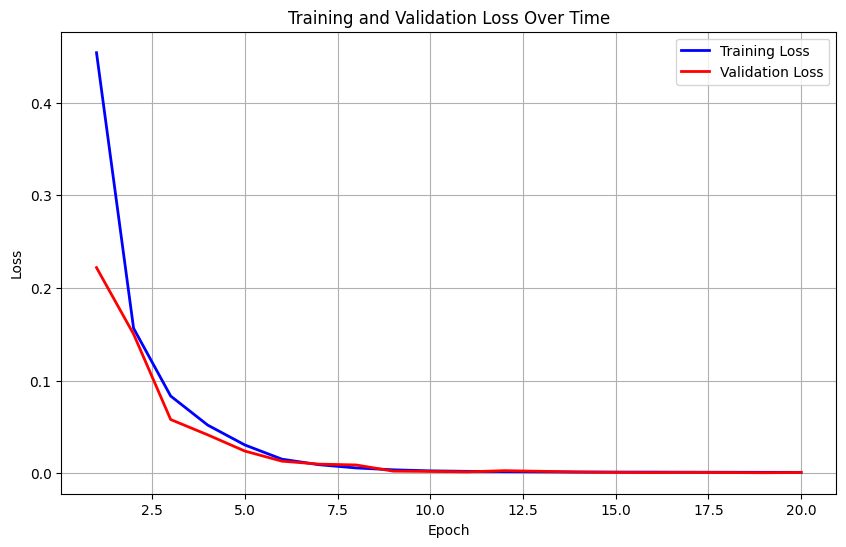

In [3]:
 
# Define the function
def f(x1, x2):
    return 3 * np.sin(np.pi*x1)*np.cos(np.pi*x2)*np.cos(np.pi**2 *x1*x2)

# Set the parameters
lower_bound = -1
upper_bound = 1
n_samples = 1000

# Generate the data
x1_values = np.linspace(lower_bound, upper_bound, n_samples).reshape(n_samples, 1)
x2_values = np.linspace(lower_bound, upper_bound, n_samples).reshape(n_samples, 1)

# Get a meshgrid for x1 and x2 values
X1, X2 = np.meshgrid(x1_values, x2_values)

# Calculate y values using the function
y_values = f(X1, X2)

# # Reshape the data for training
# X = np.column_stack((X1.ravel(), X2.ravel()))
# y = y_values.ravel()

# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Flatten the data for training
X1_flat = X1.ravel().reshape(-1, 1)  # Reshaped as a 2D array for model input
X2_flat = X2.ravel().reshape(-1, 1)  # Reshaped as a 2D array for model input
y_flat = y_values.ravel()

# Split the data into training and validation sets
X1_train, X1_val, X2_train, X2_val, y_train, y_val = train_test_split(X1_flat, X2_flat, y_flat, test_size=0.2, random_state=42)


# Assuming H1Layer, H2Layer, H3Layer, H4Layer, H5Layer, and TensorDecompositionLayer are pre-defined
def build_model(input_shape, filters):

    rank = 4
    input_x1 = Input(shape=(1,))
    input_x2 = Input(shape=(1,))

    modRelu = Relu_With_Weight()

    #Branch 1
    branch_x1 = Dense(filters)(input_x1)
    branch_x1 = Dense(filters)(branch_x1)

    #Branch 2
    branch_x2 = Dense(filters)(input_x2)
    branch_x2 = Dense(filters)(branch_x2)

    #Merge
    merged = concatenate([branch_x1, branch_x2])
    merged = Dense(filters)(merged)
    merged = Activation("tanh")(merged)
    merged = Dense(filters)(merged)
    merged = Activation("tanh")(merged)
    merged = Dense(filters)(merged)
    merged = Activation("tanh")(merged)
    merged = Dense(filters)(merged)

    output = Dense(1)(merged)  # Single output for your function
    model = Model(inputs=[input_x1, input_x2], outputs=output)

    return model 


input_shape = (2,)
filters = 128
modelN4 = build_model(input_shape, filters)
optimizer = Adam(learning_rate=0.0001) # Reduce learning rate
modelN4.compile(optimizer=optimizer, loss='mse')

batch_size = 128
epochs = 20

# history = modelN4.fit([X1_train], y_train,
#                     batch_size=batch_size,
#                     epochs=epochs,
#                     verbose=1,
#                     validation_data=(X_val, y_val),
#                     callbacks=[callback])

history = modelN4.fit([X1_train, X2_train], y_train,
                      batch_size=batch_size,
                      epochs=epochs,
                      verbose=1,
                      validation_data=([X1_val, X2_val], y_val),
                      callbacks=[callback])


val_loss = modelN4.evaluate([X1_val, X2_val], y_val, verbose=0)
print(f"Validation loss: {val_loss}")

import matplotlib.pyplot as plt
modelN4.summary()

# 1. Extract loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# 2. Determine the number of epochs
actual_epochs = len(train_loss)

# 3. Create a plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, actual_epochs + 1), train_loss, label='Training Loss', color='b', linewidth=2)
plt.plot(range(1, actual_epochs + 1), val_loss, label='Validation Loss', color='r', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.grid()
plt.show()